## ADD DESCRIPTION FOR THE PROJECT ##

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import regularizers
from keras import metrics

from sklearn.utils import shuffle
from sklearn import model_selection

from operator import itemgetter

import keras.backend as K

2022-11-20 21:34:07.294387: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-20 21:34:07.728907: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-20 21:34:07.728991: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-20 21:34:07.808373: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-20 21:34:08.961309: W tensorflow/stream_executor/platform/de

Loading data for the ML cup 2022

In [2]:
colnames = ['id', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'target1', 'target2']
mlcup_tr = pd.read_csv("./dataset/ml_cup22/ML-CUP22-TR.csv", sep = ",", names=colnames)
mlcup_tr = mlcup_tr.iloc[7:, :]
mlcup_tr = mlcup_tr.drop('id', axis=1)

In [3]:
x_mlcup_tr = mlcup_tr.iloc[:, 0:9].values
y_mlcup_tr = mlcup_tr.iloc[:, 9:11].values

Below there is the target's shape before the normalization

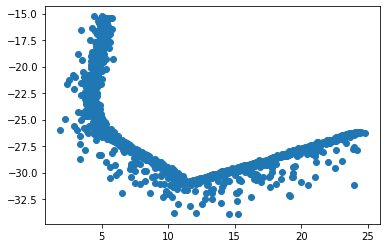

In [4]:
plt.scatter(y_mlcup_tr[:, 0], y_mlcup_tr[:, 1])

## Data Normalization ##

Let's normalize our data performing a min-max normalization

In [5]:

x_cols = len(x_mlcup_tr[0])

max_col_value_x = [None]*x_cols
max_vl = None

min_col_value_x = [None]*x_cols
min_vl = None

for i in range(x_cols):
    col = x_mlcup_tr[:, i]
    max_vl = np.amax(col)
    min_vl = np.amin(col)
    
    x_mlcup_tr[:, i] = (x_mlcup_tr[:, i] - min_vl) / (max_vl - min_vl)
    
    max_col_value_x[i] = max_vl
    min_col_value_x[i] = min_vl
    
    
    
y_cols = len(y_mlcup_tr[0])

max_col_value_y = [None]*y_cols

min_col_value_y = [None]*y_cols

for i in range(y_cols):
    col = y_mlcup_tr[:, i]
    max_vl = np.amax(col)
    min_vl = np.amin(col)
    
    y_mlcup_tr[:, i] = (y_mlcup_tr[:, i] - min_vl) / (max_vl - min_vl)
    
    max_col_value_y[i] = max_vl
    min_col_value_y[i] = min_vl 

Below there is the target shape after the normalization

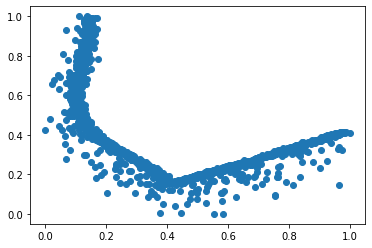

In [6]:
plt.scatter(y_mlcup_tr[:, 0], y_mlcup_tr[:, 1])

Save the number of patterns id the training set (required to compute the mean Euclidian distance)

In [7]:
num_pattern_tr = len(x_mlcup_tr)

## Neural Network with Random Search ##

Below we extended the RandomSearch class of the keras_tuner library to perform a cross validation during the phase of model selection (which is not supported by the RandomSearch class).

In [8]:
class CrossValidationRandomSearch(kt.RandomSearch):

    
    cross_validation_partitions = -1
    
    
    def __init__(
        self,
        hypermodel=None,
        objective=None,
        max_trials=10,
        seed=None,
        hyperparameters=None,
        tune_new_entries=True,
        allow_new_entries=True,
        folds_number=1,
        **kwargs
    ):
        self.cross_validation_partitions = model_selection.KFold(folds_number)
        
        
        kt.RandomSearch.__init__(
            self,
            hypermodel=hypermodel,
            objective=objective,
            max_trials=max_trials,
            seed=seed,
            hyperparameters=hyperparameters,
            tune_new_entries=tune_new_entries,
            allow_new_entries=allow_new_entries,
            **kwargs
        )

        
    def run_trial(self, trial, x_train, y_train, *args, **kwargs):
    
        histories_cv = []
        histories_folds = []
        # build a different model for each fold of the cross validation
        for train_indices, test_indices in self.cross_validation_partitions.split(x_train):
            x_cv_train, x_cv_val = x_train[train_indices], x_train[test_indices]
            y_cv_train, y_cv_val = y_train[train_indices], y_train[test_indices]
            histories_folds = super(CrossValidationRandomSearch, self).run_trial(
                trial, x_cv_train, y_cv_train, validation_data=(x_cv_val, y_cv_val), *args, **kwargs
            )
            histories_cv.append(histories_folds)

            histories_folds = []
        # return the performance of each model
        return histories_cv

Now we are about to define the mean Euclidean distance to use it as metric for the model.

In [9]:
# This function computes the mean euclidean distance for Keras
def mean_euclidean_distance(y_true, y_pred, num_pattern=1):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    return (K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))) / num_pattern

n_fold_rs = 3

num_pattern_tot = num_pattern_tr / n_fold_rs

# This is the function that we have to pass to the function model.compile()
my_mean_euclidean_distance = lambda x, y : mean_euclidean_distance(x, y, num_pattern=num_pattern_tot)

Below we defined two functions; the first one is used to create a model given a combination of hyperparameters, while the second one select a random combination of hyperparameters in a given range

In [10]:
# instantiate a model given a specific combination of hyperparameters
def set_hyperparameters(units, ridge_lambda, learning_rate, momentum, double_layer, my_metric):
    model = Sequential()
    model.add(
        Dense(
            units=units,
            activity_regularizer=regularizers.L2(ridge_lambda),
            activation="relu",
        )
    )
    # if double_layer == True, a second layer for the NN is added
    if (double_layer):
        model.add(
            Dense(
                units=units,
                activity_regularizer=regularizers.L2(ridge_lambda),
                activation="relu"
            )
        )
    model.add(Dense(2, activation="linear", activity_regularizer=regularizers.L2(ridge_lambda)))

    
    # the optimizer is the stochastic gradient descent algorithm
    opt = optimizers.SGD(learning_rate=learning_rate, momentum=momentum)

    model.compile(
        optimizer=opt, loss="mean_squared_error", metrics=[my_metric]
    )
    
    return model

# extract a random combination of hyperparamaters
def build_regressor(hp, my_metric,min_units=2, max_units=11, min_ridge_lambda=0.0001, max_ridge_lambda=0.1, min_lr_rate=0.05, 
                max_lr_rate=0.6, min_mom=0.0, max_mom=0.9, linear_lr=False, linear_reg=False, double_layer=False):
    
    
    learning_rate_sampling = "log"
    if (linear_lr):
        learning_rate_sampling = "linear"
    
    ridge_lambda_sampling = "log"
    if(linear_reg):
        ridge_lambda_sampling = "linear"
    
    units_step = 1
    if (max_units - min_units >= 5):
        units_step = 3
    
    # the variable 'units' represents the number of units of the hidden layer
    # by default this value is extracted between 2 and 11 (the user can specify a different interval)
    units = hp.Int("units", min_value=min_units, max_value=max_units, step=units_step)
    
    # the variable 'ridge_lambda' represents the lambda coefficient for ridge regularization
    # by default this value is extracted between 0.0001 and 0.1 with a logarithmic probabilistic law
    # (the user can specify a different interval)
    ridge_lambda = hp.Float(
        "ridge_lambda", min_value=min_ridge_lambda, max_value=max_ridge_lambda, sampling=ridge_lambda_sampling
    )
    
    # the variable 'learning rate' represents the step used by the stochastic gradient descent algorithm
    # by default this value is extracted between 0.1 and 0.6 (the user can specify a different interval)
    learning_rate = hp.Float(
        "learning_rate", min_value=min_lr_rate, max_value=max_lr_rate, sampling=learning_rate_sampling
    )
    
    # the variable 'momentum' represents the coefficient drawn for momentum
    # by default this value is extracted between 0.1 and 0.6 (the user can specify a different interval)
    momentum = hp.Float("momentum", min_value=min_mom, max_value=max_mom, sampling="linear")
    
    # Create the model with the set of hyperparameters drew
    model = set_hyperparameters(
        units=units, ridge_lambda=ridge_lambda, learning_rate=learning_rate, 
        momentum=momentum, double_layer=double_layer, my_metric=my_metric
    )
    return model

Let's start searching randomly the best combination of hyperparameters using only one hidden layer.

In [11]:
br_l = lambda a : build_regressor(a, my_metric=my_mean_euclidean_distance)

tuner = CrossValidationRandomSearch( 
    hypermodel=br_l, # function that return a model given a combination of hyperparameters
    objective=kt.Objective("val_<lambda>", direction="min"), # value to minimize
    max_trials=30, #50, # maximum number of attempts RIPRISTINA POI
    executions_per_trial=2, # number of models created for each fold of the cross validation
    overwrite=True,
    directory="results/ml_cup",
    project_name="nn_RandomSearch/single_layer/first/par_hp",
    folds_number=3 # number of folds of the cross validation
)

2022-11-20 21:34:10.841895: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-20 21:34:10.842166: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-20 21:34:10.842183: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (carlo-Aspire-A515-52G): /proc/driver/nvidia/version does not exist
2022-11-20 21:34:10.842546: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


print a brief description of the search space

In [12]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 11, 'step': 3, 'sampling': None}
ridge_lambda (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
learning_rate (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.6, 'step': None, 'sampling': 'log'}
momentum (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.9, 'step': None, 'sampling': 'linear'}


In [13]:
tuner.search(
    # the training set for the model selection
    x_mlcup_tr, y_mlcup_tr,
    # maximum number of epochs allowed
    epochs=2500,
    # callback to implement early stopping
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)],
    shuffle=True,
)

Trial 30 Complete [00h 00m 13s]
val_<lambda>: 0.0003999843223330875

Best val_<lambda> So Far: 0.0001829078197867299
Total elapsed time: 00h 18m 17s
INFO:tensorflow:Oracle triggered exit


In [14]:
best_hp = tuner.get_best_hyperparameters(3)

print("results of the first random search with a single hidden layer\n")
for i in range(len(best_hp)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "ridge_lambda", "learning_rate", "momentum"]:
        print(h_param, best_hp[i].get(h_param))
    print("")

results of the first random search with a single hidden layer

best hyperparameters n. 0
units 8
ridge_lambda 0.0015377893817187592
learning_rate 0.06630783187830605
momentum 0.3124276253571157

best hyperparameters n. 1
units 8
ridge_lambda 0.014580983761541077
learning_rate 0.10548608970407594
momentum 0.7002277252975055

best hyperparameters n. 2
units 11
ridge_lambda 0.023149987824681327
learning_rate 0.12773305387480166
momentum 0.5381725203998897



Brief description of the final neural network's structure

In [15]:
f_model = br_l(best_hp[0])
f_model.build(
input_shape=(None, 9))

f_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8)                 80        
                                                                 
 dense_3 (Dense)             (None, 2)                 18        
                                                                 
Total params: 98
Trainable params: 98
Non-trainable params: 0
_________________________________________________________________


In [16]:
tuner.results_summary()

Results summary
Results in results/ml_cup/nn_RandomSearch/single_layer/first/par_hp
Showing 10 best trials
Trial summary
Hyperparameters:
units: 8
ridge_lambda: 0.0015377893817187592
learning_rate: 0.06630783187830605
momentum: 0.3124276253571157
Score: 0.0001829078197867299
Trial summary
Hyperparameters:
units: 8
ridge_lambda: 0.014580983761541077
learning_rate: 0.10548608970407594
momentum: 0.7002277252975055
Score: 0.00018316346055750424
Trial summary
Hyperparameters:
units: 11
ridge_lambda: 0.023149987824681327
learning_rate: 0.12773305387480166
momentum: 0.5381725203998897
Score: 0.000184823574575906
Trial summary
Hyperparameters:
units: 11
ridge_lambda: 0.010412082992309528
learning_rate: 0.056980617427985464
momentum: 0.32514500035848926
Score: 0.00018607072949331874
Trial summary
Hyperparameters:
units: 8
ridge_lambda: 0.020576934850711857
learning_rate: 0.19473740690109514
momentum: 0.28604936212266213
Score: 0.00018639198484985778
Trial summary
Hyperparameters:
units: 8
ridge

Now we have found a first best set of hyperparameters. At this point, we are ready to perform a second nested random search to explore the space around the best set of hyperparameters found.

In [17]:
h_param = ["units", "ridge_lambda", "learning_rate", "momentum"]

num_units = best_hp[0].get(h_param[0])
ridge_lambda = best_hp[0].get(h_param[1])
learning_rate = best_hp[0].get(h_param[2])
momentum = best_hp[0].get(h_param[3])
double_layer = False

ridge_lambda_min = (ridge_lambda / 10) * 8
ridge_lambda_max = (ridge_lambda / 10) * 12

learning_rate_min = (learning_rate / 10) * 8
learning_rate_max = (learning_rate / 10) * 12

momentum_min = (momentum / 10) * 8
momentum_max = (momentum / 10) * 12

# This lambda function has been used to specify the space of the hyperparameters that we want to explore
br_l2 = lambda a: build_regressor(
    a, my_metric=my_mean_euclidean_distance,
    min_units=num_units, max_units=num_units, min_ridge_lambda=ridge_lambda_min,
    max_ridge_lambda=ridge_lambda_max, min_lr_rate=learning_rate_min,
    max_lr_rate=learning_rate_max,min_mom=momentum_min, max_mom=momentum_max, 
    linear_lr=True, linear_reg=True, double_layer=double_layer
)

tuner2 = CrossValidationRandomSearch(
    hypermodel=br_l2, # function which return a model given a combination of hyperparameters
    objective=kt.Objective("val_<lambda>", direction="min"), # value to minimize
    max_trials=30, # maximum number of attempts
    executions_per_trial=2, # models created for each fold of the cross validation
    overwrite=True,
    directory="results/ml_cup",
    project_name="nn_RandomSearch/single_layer/nested/par_hp",
    folds_number=3 # number of folds of the cross validation
)

Again, below there is a brief summary of the search space

In [18]:
tuner2.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 8, 'step': 1, 'sampling': None}
ridge_lambda (Float)
{'default': 0.0012302315053750073, 'conditions': [], 'min_value': 0.0012302315053750073, 'max_value': 0.0018453472580625108, 'step': None, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.05304626550264484, 'conditions': [], 'min_value': 0.05304626550264484, 'max_value': 0.07956939825396725, 'step': None, 'sampling': 'linear'}
momentum (Float)
{'default': 0.24994210028569258, 'conditions': [], 'min_value': 0.24994210028569258, 'max_value': 0.3749131504285389, 'step': None, 'sampling': 'linear'}


On the cell below we started the second nested random search (with again only one hidden layer)

In [19]:
tuner2.search(
    x_mlcup_tr, y_mlcup_tr, # training set for the random search 
    epochs=2500, # maximum number of epochs allowed
    # callback to implement early stopping
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)],
    shuffle=True
)

Trial 30 Complete [00h 01m 43s]
val_<lambda>: 0.00018727665883488953

Best val_<lambda> So Far: 0.0001802706901798956
Total elapsed time: 00h 48m 13s
INFO:tensorflow:Oracle triggered exit


Let's print again the best combination of hyperparameters found during this second nested random search

In [20]:
best_hp2 = tuner2.get_best_hyperparameters(3)

print("results of the second nested random search with a single hidden layer\n")
for i in range(len(best_hp2)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "ridge_lambda", "learning_rate", "momentum"]:
        print(h_param, best_hp2[i].get(h_param))
    print("")

results of the second nested random search with a single hidden layer

best hyperparameters n. 0
units 8
ridge_lambda 0.0014152080395758177
learning_rate 0.07902762137955638
momentum 0.34804305409602687

best hyperparameters n. 1
units 8
ridge_lambda 0.0013799508298952244
learning_rate 0.0739226036530139
momentum 0.37359812270357945

best hyperparameters n. 2
units 8
ridge_lambda 0.0017365338490469978
learning_rate 0.07082254892832575
momentum 0.3199140114656045



Brief description of the final neural network's structure

In [21]:
br_l2 = lambda a : build_regressor(a, my_metric=my_mean_euclidean_distance)

f_model2 = br_l2(best_hp2[0])
f_model2.build(
input_shape=(None, 9))

f_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8)                 80        
                                                                 
 dense_3 (Dense)             (None, 2)                 18        
                                                                 
Total params: 98
Trainable params: 98
Non-trainable params: 0
_________________________________________________________________


At this point we tried many neural networks using the best hyperparameters found by the second nested random search. Below we split the design set between training set and validation set. Remember that here we are using only one hidden layer

In [22]:
subset_size = int(0.3 * len(x_mlcup_tr))

index = np.random.choice(len(x_mlcup_tr), subset_size, replace=False)
index = np.sort(index)

x_mlcup_ds = x_mlcup_tr
y_mlcup_ds = y_mlcup_tr

x_mlcup_vl = x_mlcup_ds[index]
y_mlcup_vl = y_mlcup_ds[index]

x_mlcup_tr = np.delete(x_mlcup_ds, index, 0)
y_mlcup_tr = np.delete(y_mlcup_ds, index, 0)

In [23]:
n_trials = 10

models = [None]*n_trials

for i in range(n_trials):
    models[i] = br_l2(best_hp2[0])

n_epochs = 1000
hist = [None]*n_trials

for i in range(n_trials):
        hist[i] = models[i].fit(
            x=x_mlcup_tr,
            y=y_mlcup_tr,
            validation_data=(x_mlcup_vl, y_mlcup_vl),
            epochs=n_epochs,
            shuffle=True,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)]
        )

Epoch 1/1000
33/33 [==============================] - 1s 6ms/step - loss: 0.0532 - <lambda>: 5.3460e-04 - val_loss: 0.0243 - val_<lambda>: 3.7477e-04
Epoch 2/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0228 - <lambda>: 3.6696e-04 - val_loss: 0.0187 - val_<lambda>: 3.2164e-04
Epoch 3/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0184 - <lambda>: 3.2206e-04 - val_loss: 0.0173 - val_<lambda>: 3.0376e-04
Epoch 4/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0166 - <lambda>: 3.0246e-04 - val_loss: 0.0156 - val_<lambda>: 2.8756e-04
Epoch 5/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0154 - <lambda>: 2.9059e-04 - val_loss: 0.0150 - val_<lambda>: 2.8262e-04
Epoch 6/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0146 - <lambda>: 2.8065e-04 - val_loss: 0.0142 - val_<lambda>: 2.7505e-04
Epoch 7/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0140 - <lambda>: 2.7506e

33/33 [==============================] - 0s 2ms/step - loss: 0.0067 - <lambda>: 1.7228e-04 - val_loss: 0.0075 - val_<lambda>: 1.8248e-04
Epoch 110/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0068 - <lambda>: 1.7227e-04 - val_loss: 0.0076 - val_<lambda>: 1.8468e-04
Epoch 111/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0067 - <lambda>: 1.7220e-04 - val_loss: 0.0075 - val_<lambda>: 1.8222e-04
Epoch 112/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0067 - <lambda>: 1.7211e-04 - val_loss: 0.0075 - val_<lambda>: 1.8324e-04
Epoch 113/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0067 - <lambda>: 1.7156e-04 - val_loss: 0.0075 - val_<lambda>: 1.8200e-04
Epoch 114/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0067 - <lambda>: 1.7218e-04 - val_loss: 0.0076 - val_<lambda>: 1.8464e-04
Epoch 115/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0067 - <lambda>: 1.7138e-

Epoch 163/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0063 - <lambda>: 1.6556e-04 - val_loss: 0.0071 - val_<lambda>: 1.7639e-04
Epoch 164/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0063 - <lambda>: 1.6453e-04 - val_loss: 0.0071 - val_<lambda>: 1.7790e-04
Epoch 165/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0063 - <lambda>: 1.6502e-04 - val_loss: 0.0072 - val_<lambda>: 1.7879e-04
Epoch 166/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0063 - <lambda>: 1.6501e-04 - val_loss: 0.0071 - val_<lambda>: 1.7834e-04
Epoch 167/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0063 - <lambda>: 1.6450e-04 - val_loss: 0.0071 - val_<lambda>: 1.7654e-04
Epoch 168/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0063 - <lambda>: 1.6440e-04 - val_loss: 0.0072 - val_<lambda>: 1.7858e-04
Epoch 169/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0063 - <la

Epoch 217/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0061 - <lambda>: 1.6116e-04 - val_loss: 0.0069 - val_<lambda>: 1.7375e-04
Epoch 218/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0061 - <lambda>: 1.6060e-04 - val_loss: 0.0069 - val_<lambda>: 1.7499e-04
Epoch 219/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0061 - <lambda>: 1.6112e-04 - val_loss: 0.0070 - val_<lambda>: 1.7807e-04
Epoch 220/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0060 - <lambda>: 1.6104e-04 - val_loss: 0.0070 - val_<lambda>: 1.7765e-04
Epoch 221/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0060 - <lambda>: 1.6067e-04 - val_loss: 0.0069 - val_<lambda>: 1.7462e-04
Epoch 222/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0060 - <lambda>: 1.6092e-04 - val_loss: 0.0069 - val_<lambda>: 1.7501e-04
Epoch 223/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0060 - <la

33/33 [==============================] - 0s 2ms/step - loss: 0.0091 - <lambda>: 2.1393e-04 - val_loss: 0.0093 - val_<lambda>: 2.1629e-04
Epoch 77/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0091 - <lambda>: 2.1443e-04 - val_loss: 0.0096 - val_<lambda>: 2.1967e-04
Epoch 78/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0091 - <lambda>: 2.1378e-04 - val_loss: 0.0093 - val_<lambda>: 2.1671e-04
Epoch 79/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0090 - <lambda>: 2.1362e-04 - val_loss: 0.0093 - val_<lambda>: 2.1654e-04
Epoch 80/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0090 - <lambda>: 2.1334e-04 - val_loss: 0.0096 - val_<lambda>: 2.2028e-04
Epoch 81/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0090 - <lambda>: 2.1325e-04 - val_loss: 0.0094 - val_<lambda>: 2.1721e-04
Epoch 82/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0090 - <lambda>: 2.1348e-04 - v

Epoch 184/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 1.9025e-04 - val_loss: 0.0080 - val_<lambda>: 1.9971e-04
Epoch 185/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 1.9025e-04 - val_loss: 0.0081 - val_<lambda>: 2.0107e-04
Epoch 186/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 1.9054e-04 - val_loss: 0.0082 - val_<lambda>: 2.0236e-04
Epoch 187/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 1.9037e-04 - val_loss: 0.0080 - val_<lambda>: 1.9942e-04
Epoch 188/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 1.8955e-04 - val_loss: 0.0080 - val_<lambda>: 1.9920e-04
Epoch 189/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 1.8919e-04 - val_loss: 0.0080 - val_<lambda>: 1.9928e-04
Epoch 190/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <la

Epoch 238/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0072 - <lambda>: 1.8505e-04 - val_loss: 0.0079 - val_<lambda>: 1.9506e-04
Epoch 239/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0072 - <lambda>: 1.8492e-04 - val_loss: 0.0077 - val_<lambda>: 1.9340e-04
Epoch 240/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0073 - <lambda>: 1.8621e-04 - val_loss: 0.0078 - val_<lambda>: 1.9491e-04
Epoch 241/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0072 - <lambda>: 1.8450e-04 - val_loss: 0.0077 - val_<lambda>: 1.9310e-04
Epoch 242/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0072 - <lambda>: 1.8524e-04 - val_loss: 0.0078 - val_<lambda>: 1.9355e-04
Epoch 243/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0072 - <lambda>: 1.8491e-04 - val_loss: 0.0077 - val_<lambda>: 1.9297e-04
Epoch 244/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0072 - <la

Epoch 292/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0070 - <lambda>: 1.8078e-04 - val_loss: 0.0080 - val_<lambda>: 1.9641e-04
Epoch 293/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0070 - <lambda>: 1.8235e-04 - val_loss: 0.0076 - val_<lambda>: 1.9202e-04
Epoch 294/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0070 - <lambda>: 1.8150e-04 - val_loss: 0.0076 - val_<lambda>: 1.9149e-04
Epoch 295/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0070 - <lambda>: 1.8081e-04 - val_loss: 0.0076 - val_<lambda>: 1.9185e-04
Epoch 296/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0070 - <lambda>: 1.8147e-04 - val_loss: 0.0076 - val_<lambda>: 1.9194e-04
Epoch 297/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0070 - <lambda>: 1.8072e-04 - val_loss: 0.0076 - val_<lambda>: 1.9172e-04
Epoch 298/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0070 - <la

Epoch 346/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0069 - <lambda>: 1.7966e-04 - val_loss: 0.0075 - val_<lambda>: 1.9002e-04
Epoch 347/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0068 - <lambda>: 1.7916e-04 - val_loss: 0.0076 - val_<lambda>: 1.9112e-04
Epoch 348/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0068 - <lambda>: 1.7795e-04 - val_loss: 0.0075 - val_<lambda>: 1.8964e-04
Epoch 1/1000
33/33 [==============================] - 1s 5ms/step - loss: 0.0696 - <lambda>: 6.4464e-04 - val_loss: 0.0408 - val_<lambda>: 5.0339e-04
Epoch 2/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0342 - <lambda>: 4.5338e-04 - val_loss: 0.0277 - val_<lambda>: 4.0820e-04
Epoch 3/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0261 - <lambda>: 3.9197e-04 - val_loss: 0.0232 - val_<lambda>: 3.6327e-04
Epoch 4/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0224 - <lambda>: 3

33/33 [==============================] - 0s 2ms/step - loss: 0.0072 - <lambda>: 1.8401e-04 - val_loss: 0.0079 - val_<lambda>: 1.9395e-04
Epoch 107/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0072 - <lambda>: 1.8470e-04 - val_loss: 0.0079 - val_<lambda>: 1.9488e-04
Epoch 108/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0072 - <lambda>: 1.8395e-04 - val_loss: 0.0078 - val_<lambda>: 1.9262e-04
Epoch 109/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0072 - <lambda>: 1.8380e-04 - val_loss: 0.0078 - val_<lambda>: 1.9249e-04
Epoch 110/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0071 - <lambda>: 1.8321e-04 - val_loss: 0.0077 - val_<lambda>: 1.9209e-04
Epoch 111/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0072 - <lambda>: 1.8313e-04 - val_loss: 0.0077 - val_<lambda>: 1.9171e-04
Epoch 112/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0071 - <lambda>: 1.8357e-

Epoch 160/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <lambda>: 1.7374e-04 - val_loss: 0.0073 - val_<lambda>: 1.8578e-04
Epoch 161/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <lambda>: 1.7396e-04 - val_loss: 0.0072 - val_<lambda>: 1.8450e-04
Epoch 162/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <lambda>: 1.7352e-04 - val_loss: 0.0073 - val_<lambda>: 1.8507e-04
Epoch 163/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <lambda>: 1.7370e-04 - val_loss: 0.0072 - val_<lambda>: 1.8408e-04
Epoch 164/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <lambda>: 1.7327e-04 - val_loss: 0.0072 - val_<lambda>: 1.8414e-04
Epoch 165/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <lambda>: 1.7327e-04 - val_loss: 0.0072 - val_<lambda>: 1.8432e-04
Epoch 166/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <la

Epoch 214/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0063 - <lambda>: 1.6810e-04 - val_loss: 0.0071 - val_<lambda>: 1.8156e-04
Epoch 215/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0063 - <lambda>: 1.6811e-04 - val_loss: 0.0070 - val_<lambda>: 1.8132e-04
Epoch 216/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0063 - <lambda>: 1.6810e-04 - val_loss: 0.0071 - val_<lambda>: 1.8245e-04
Epoch 217/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0062 - <lambda>: 1.6790e-04 - val_loss: 0.0071 - val_<lambda>: 1.8197e-04
Epoch 218/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0062 - <lambda>: 1.6700e-04 - val_loss: 0.0071 - val_<lambda>: 1.8262e-04
Epoch 219/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0062 - <lambda>: 1.6803e-04 - val_loss: 0.0073 - val_<lambda>: 1.8510e-04
Epoch 220/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0063 - <la

Epoch 268/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0061 - <lambda>: 1.6553e-04 - val_loss: 0.0070 - val_<lambda>: 1.7980e-04
Epoch 269/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0062 - <lambda>: 1.6566e-04 - val_loss: 0.0069 - val_<lambda>: 1.8017e-04
Epoch 270/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0061 - <lambda>: 1.6569e-04 - val_loss: 0.0070 - val_<lambda>: 1.7995e-04
Epoch 271/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0061 - <lambda>: 1.6553e-04 - val_loss: 0.0070 - val_<lambda>: 1.8128e-04
Epoch 272/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0061 - <lambda>: 1.6590e-04 - val_loss: 0.0071 - val_<lambda>: 1.8099e-04
Epoch 1/1000
33/33 [==============================] - 1s 5ms/step - loss: 0.0812 - <lambda>: 7.3152e-04 - val_loss: 0.0588 - val_<lambda>: 6.1484e-04
Epoch 2/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0438 - <lambda

33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - <lambda>: 2.0702e-04 - val_loss: 0.0092 - val_<lambda>: 2.1586e-04
Epoch 105/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - <lambda>: 2.0505e-04 - val_loss: 0.0092 - val_<lambda>: 2.1604e-04
Epoch 106/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - <lambda>: 2.0526e-04 - val_loss: 0.0095 - val_<lambda>: 2.1960e-04
Epoch 107/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - <lambda>: 2.0499e-04 - val_loss: 0.0092 - val_<lambda>: 2.1590e-04
Epoch 108/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - <lambda>: 2.0514e-04 - val_loss: 0.0092 - val_<lambda>: 2.1606e-04
Epoch 109/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - <lambda>: 2.0550e-04 - val_loss: 0.0091 - val_<lambda>: 2.1568e-04
Epoch 110/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - <lambda>: 2.0533e-

Epoch 158/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 2.0094e-04 - val_loss: 0.0087 - val_<lambda>: 2.1010e-04
Epoch 159/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 2.0079e-04 - val_loss: 0.0087 - val_<lambda>: 2.1106e-04
Epoch 160/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 2.0066e-04 - val_loss: 0.0089 - val_<lambda>: 2.1521e-04
Epoch 161/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 2.0068e-04 - val_loss: 0.0087 - val_<lambda>: 2.1039e-04
Epoch 162/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 2.0014e-04 - val_loss: 0.0087 - val_<lambda>: 2.0986e-04
Epoch 163/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <lambda>: 2.0027e-04 - val_loss: 0.0087 - val_<lambda>: 2.1109e-04
Epoch 164/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <la

Epoch 212/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 1.9190e-04 - val_loss: 0.0077 - val_<lambda>: 1.9593e-04
Epoch 213/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 1.9107e-04 - val_loss: 0.0078 - val_<lambda>: 1.9705e-04
Epoch 214/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 1.9113e-04 - val_loss: 0.0078 - val_<lambda>: 1.9761e-04
Epoch 215/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 1.9156e-04 - val_loss: 0.0077 - val_<lambda>: 1.9551e-04
Epoch 216/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 1.9064e-04 - val_loss: 0.0077 - val_<lambda>: 1.9522e-04
Epoch 217/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 1.9005e-04 - val_loss: 0.0077 - val_<lambda>: 1.9551e-04
Epoch 218/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0073 - <la

Epoch 266/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0069 - <lambda>: 1.8128e-04 - val_loss: 0.0072 - val_<lambda>: 1.8723e-04
Epoch 267/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0069 - <lambda>: 1.8100e-04 - val_loss: 0.0073 - val_<lambda>: 1.8775e-04
Epoch 268/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0068 - <lambda>: 1.8042e-04 - val_loss: 0.0073 - val_<lambda>: 1.8778e-04
Epoch 269/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0068 - <lambda>: 1.8086e-04 - val_loss: 0.0072 - val_<lambda>: 1.8718e-04
Epoch 270/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0068 - <lambda>: 1.8035e-04 - val_loss: 0.0073 - val_<lambda>: 1.8678e-04
Epoch 271/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0068 - <lambda>: 1.7998e-04 - val_loss: 0.0072 - val_<lambda>: 1.8655e-04
Epoch 272/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0069 - <la

33/33 [==============================] - 0s 2ms/step - loss: 0.0089 - <lambda>: 2.1221e-04 - val_loss: 0.0097 - val_<lambda>: 2.1972e-04
Epoch 88/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0090 - <lambda>: 2.1239e-04 - val_loss: 0.0096 - val_<lambda>: 2.1962e-04
Epoch 89/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0089 - <lambda>: 2.1150e-04 - val_loss: 0.0099 - val_<lambda>: 2.2234e-04
Epoch 90/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0089 - <lambda>: 2.1218e-04 - val_loss: 0.0099 - val_<lambda>: 2.2280e-04
Epoch 91/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0089 - <lambda>: 2.1204e-04 - val_loss: 0.0096 - val_<lambda>: 2.1964e-04
Epoch 92/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0089 - <lambda>: 2.1082e-04 - val_loss: 0.0096 - val_<lambda>: 2.1866e-04
Epoch 93/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0088 - <lambda>: 2.1077e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - <lambda>: 2.0687e-04 - val_loss: 0.0092 - val_<lambda>: 2.1597e-04
Epoch 142/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0084 - <lambda>: 2.0612e-04 - val_loss: 0.0095 - val_<lambda>: 2.1964e-04
Epoch 143/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0084 - <lambda>: 2.0654e-04 - val_loss: 0.0091 - val_<lambda>: 2.1490e-04
Epoch 144/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - <lambda>: 2.0696e-04 - val_loss: 0.0092 - val_<lambda>: 2.1562e-04
Epoch 145/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0084 - <lambda>: 2.0567e-04 - val_loss: 0.0091 - val_<lambda>: 2.1505e-04
Epoch 146/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - <lambda>: 2.0677e-04 - val_loss: 0.0094 - val_<lambda>: 2.1965e-04
Epoch 147/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0084 - <lambda>: 2.0668e-

Epoch 195/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 2.0502e-04 - val_loss: 0.0091 - val_<lambda>: 2.1702e-04
Epoch 196/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 2.0528e-04 - val_loss: 0.0090 - val_<lambda>: 2.1427e-04
Epoch 197/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 2.0515e-04 - val_loss: 0.0092 - val_<lambda>: 2.1612e-04
Epoch 198/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 2.0486e-04 - val_loss: 0.0090 - val_<lambda>: 2.1440e-04
Epoch 199/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 2.0507e-04 - val_loss: 0.0090 - val_<lambda>: 2.1393e-04
Epoch 200/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 2.0483e-04 - val_loss: 0.0090 - val_<lambda>: 2.1472e-04
Epoch 201/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <la

33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 1.9880e-04 - val_loss: 0.0088 - val_<lambda>: 2.0656e-04
Epoch 100/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 1.9886e-04 - val_loss: 0.0088 - val_<lambda>: 2.0678e-04
Epoch 101/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 1.9957e-04 - val_loss: 0.0089 - val_<lambda>: 2.0899e-04
Epoch 102/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 1.9969e-04 - val_loss: 0.0089 - val_<lambda>: 2.0830e-04
Epoch 103/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 1.9960e-04 - val_loss: 0.0088 - val_<lambda>: 2.0740e-04
Epoch 104/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 1.9928e-04 - val_loss: 0.0088 - val_<lambda>: 2.0666e-04
Epoch 105/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 1.9828e-

Epoch 153/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 1.9503e-04 - val_loss: 0.0084 - val_<lambda>: 2.0238e-04
Epoch 154/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 1.9399e-04 - val_loss: 0.0084 - val_<lambda>: 2.0290e-04
Epoch 155/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 1.9471e-04 - val_loss: 0.0087 - val_<lambda>: 2.0760e-04
Epoch 156/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 1.9487e-04 - val_loss: 0.0084 - val_<lambda>: 2.0310e-04
Epoch 157/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 1.9446e-04 - val_loss: 0.0084 - val_<lambda>: 2.0265e-04
Epoch 158/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 1.9488e-04 - val_loss: 0.0084 - val_<lambda>: 2.0325e-04
Epoch 159/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <la

Epoch 207/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 1.9095e-04 - val_loss: 0.0080 - val_<lambda>: 1.9491e-04
Epoch 208/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 1.8979e-04 - val_loss: 0.0080 - val_<lambda>: 1.9475e-04
Epoch 209/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 1.8923e-04 - val_loss: 0.0087 - val_<lambda>: 2.0882e-04
Epoch 210/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 1.8885e-04 - val_loss: 0.0080 - val_<lambda>: 1.9532e-04
Epoch 211/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 1.8948e-04 - val_loss: 0.0086 - val_<lambda>: 2.0607e-04
Epoch 212/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 1.8917e-04 - val_loss: 0.0080 - val_<lambda>: 1.9324e-04
Epoch 213/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <la

Epoch 261/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0068 - <lambda>: 1.7722e-04 - val_loss: 0.0074 - val_<lambda>: 1.8545e-04
Epoch 262/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0068 - <lambda>: 1.7785e-04 - val_loss: 0.0074 - val_<lambda>: 1.8485e-04
Epoch 263/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0068 - <lambda>: 1.7684e-04 - val_loss: 0.0074 - val_<lambda>: 1.8774e-04
Epoch 264/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0068 - <lambda>: 1.7731e-04 - val_loss: 0.0074 - val_<lambda>: 1.8667e-04
Epoch 265/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0068 - <lambda>: 1.7756e-04 - val_loss: 0.0074 - val_<lambda>: 1.8490e-04
Epoch 266/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0068 - <lambda>: 1.7603e-04 - val_loss: 0.0075 - val_<lambda>: 1.8882e-04
Epoch 267/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0067 - <la

Epoch 315/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0065 - <lambda>: 1.7183e-04 - val_loss: 0.0072 - val_<lambda>: 1.8246e-04
Epoch 316/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0065 - <lambda>: 1.7136e-04 - val_loss: 0.0071 - val_<lambda>: 1.8276e-04
Epoch 317/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0065 - <lambda>: 1.7134e-04 - val_loss: 0.0072 - val_<lambda>: 1.8307e-04
Epoch 318/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0064 - <lambda>: 1.7136e-04 - val_loss: 0.0073 - val_<lambda>: 1.8734e-04
Epoch 319/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0065 - <lambda>: 1.7155e-04 - val_loss: 0.0072 - val_<lambda>: 1.8349e-04
Epoch 320/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0065 - <lambda>: 1.7157e-04 - val_loss: 0.0071 - val_<lambda>: 1.8266e-04
Epoch 321/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0064 - <la

Epoch 369/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0063 - <lambda>: 1.6881e-04 - val_loss: 0.0070 - val_<lambda>: 1.8244e-04
Epoch 370/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0062 - <lambda>: 1.6892e-04 - val_loss: 0.0071 - val_<lambda>: 1.8386e-04
Epoch 371/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0062 - <lambda>: 1.6814e-04 - val_loss: 0.0070 - val_<lambda>: 1.8344e-04
Epoch 372/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0063 - <lambda>: 1.6939e-04 - val_loss: 0.0070 - val_<lambda>: 1.8164e-04
Epoch 373/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0062 - <lambda>: 1.6797e-04 - val_loss: 0.0070 - val_<lambda>: 1.8176e-04
Epoch 374/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0062 - <lambda>: 1.6815e-04 - val_loss: 0.0070 - val_<lambda>: 1.8168e-04
Epoch 375/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0063 - <la

33/33 [==============================] - 0s 2ms/step - loss: 0.0119 - <lambda>: 2.4727e-04 - val_loss: 0.0128 - val_<lambda>: 2.5590e-04
Epoch 16/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0116 - <lambda>: 2.4434e-04 - val_loss: 0.0126 - val_<lambda>: 2.5229e-04
Epoch 17/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0114 - <lambda>: 2.4138e-04 - val_loss: 0.0123 - val_<lambda>: 2.4925e-04
Epoch 18/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0111 - <lambda>: 2.3765e-04 - val_loss: 0.0121 - val_<lambda>: 2.4695e-04
Epoch 19/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0110 - <lambda>: 2.3672e-04 - val_loss: 0.0119 - val_<lambda>: 2.4420e-04
Epoch 20/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0108 - <lambda>: 2.3320e-04 - val_loss: 0.0118 - val_<lambda>: 2.4333e-04
Epoch 21/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0106 - <lambda>: 2.3234e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0072 - <lambda>: 1.8565e-04 - val_loss: 0.0079 - val_<lambda>: 1.9418e-04
Epoch 124/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0072 - <lambda>: 1.8624e-04 - val_loss: 0.0079 - val_<lambda>: 1.9542e-04
Epoch 125/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0073 - <lambda>: 1.8625e-04 - val_loss: 0.0080 - val_<lambda>: 1.9640e-04
Epoch 126/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0072 - <lambda>: 1.8570e-04 - val_loss: 0.0080 - val_<lambda>: 1.9486e-04
Epoch 127/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0072 - <lambda>: 1.8594e-04 - val_loss: 0.0080 - val_<lambda>: 1.9404e-04
Epoch 128/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0072 - <lambda>: 1.8592e-04 - val_loss: 0.0079 - val_<lambda>: 1.9344e-04
Epoch 129/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0072 - <lambda>: 1.8537e-

Epoch 177/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0069 - <lambda>: 1.8135e-04 - val_loss: 0.0077 - val_<lambda>: 1.9361e-04
Epoch 178/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0068 - <lambda>: 1.7990e-04 - val_loss: 0.0076 - val_<lambda>: 1.8963e-04
Epoch 179/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0068 - <lambda>: 1.7991e-04 - val_loss: 0.0077 - val_<lambda>: 1.9329e-04
Epoch 180/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0068 - <lambda>: 1.7982e-04 - val_loss: 0.0076 - val_<lambda>: 1.8986e-04
Epoch 181/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0068 - <lambda>: 1.7977e-04 - val_loss: 0.0076 - val_<lambda>: 1.8947e-04
Epoch 182/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0068 - <lambda>: 1.7971e-04 - val_loss: 0.0076 - val_<lambda>: 1.9067e-04
Epoch 183/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0068 - <la

Epoch 231/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <lambda>: 1.7625e-04 - val_loss: 0.0074 - val_<lambda>: 1.8673e-04
Epoch 232/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <lambda>: 1.7613e-04 - val_loss: 0.0074 - val_<lambda>: 1.8701e-04
Epoch 233/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <lambda>: 1.7558e-04 - val_loss: 0.0074 - val_<lambda>: 1.8824e-04
Epoch 234/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <lambda>: 1.7601e-04 - val_loss: 0.0074 - val_<lambda>: 1.8674e-04
Epoch 235/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <lambda>: 1.7609e-04 - val_loss: 0.0074 - val_<lambda>: 1.8795e-04
Epoch 236/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <lambda>: 1.7575e-04 - val_loss: 0.0074 - val_<lambda>: 1.8722e-04
Epoch 237/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <la

Epoch 285/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0064 - <lambda>: 1.7361e-04 - val_loss: 0.0073 - val_<lambda>: 1.8691e-04
Epoch 286/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0064 - <lambda>: 1.7316e-04 - val_loss: 0.0072 - val_<lambda>: 1.8564e-04
Epoch 287/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0064 - <lambda>: 1.7306e-04 - val_loss: 0.0073 - val_<lambda>: 1.8652e-04
Epoch 288/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0064 - <lambda>: 1.7284e-04 - val_loss: 0.0073 - val_<lambda>: 1.8701e-04
Epoch 289/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0064 - <lambda>: 1.7351e-04 - val_loss: 0.0072 - val_<lambda>: 1.8582e-04
Epoch 290/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0064 - <lambda>: 1.7332e-04 - val_loss: 0.0072 - val_<lambda>: 1.8532e-04
Epoch 291/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0064 - <la

Epoch 339/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0063 - <lambda>: 1.7175e-04 - val_loss: 0.0072 - val_<lambda>: 1.8470e-04
Epoch 340/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0063 - <lambda>: 1.7173e-04 - val_loss: 0.0072 - val_<lambda>: 1.8458e-04
Epoch 341/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0063 - <lambda>: 1.7099e-04 - val_loss: 0.0071 - val_<lambda>: 1.8425e-04
Epoch 342/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0063 - <lambda>: 1.7129e-04 - val_loss: 0.0072 - val_<lambda>: 1.8523e-04
Epoch 343/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0063 - <lambda>: 1.7096e-04 - val_loss: 0.0072 - val_<lambda>: 1.8489e-04
Epoch 344/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0063 - <lambda>: 1.7139e-04 - val_loss: 0.0072 - val_<lambda>: 1.8640e-04
Epoch 345/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0063 - <la

33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 2.0082e-04 - val_loss: 0.0089 - val_<lambda>: 2.1054e-04
Epoch 84/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 2.0081e-04 - val_loss: 0.0089 - val_<lambda>: 2.1093e-04
Epoch 85/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 2.0099e-04 - val_loss: 0.0089 - val_<lambda>: 2.1045e-04
Epoch 86/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 2.0021e-04 - val_loss: 0.0089 - val_<lambda>: 2.1068e-04
Epoch 87/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0082 - <lambda>: 2.0117e-04 - val_loss: 0.0089 - val_<lambda>: 2.1059e-04
Epoch 88/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 2.0137e-04 - val_loss: 0.0091 - val_<lambda>: 2.1397e-04
Epoch 89/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 2.0037e-04 - v

Epoch 191/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0072 - <lambda>: 1.8727e-04 - val_loss: 0.0079 - val_<lambda>: 1.9739e-04
Epoch 192/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0071 - <lambda>: 1.8701e-04 - val_loss: 0.0078 - val_<lambda>: 1.9480e-04
Epoch 193/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0071 - <lambda>: 1.8654e-04 - val_loss: 0.0078 - val_<lambda>: 1.9506e-04
Epoch 194/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0071 - <lambda>: 1.8695e-04 - val_loss: 0.0078 - val_<lambda>: 1.9602e-04
Epoch 195/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0071 - <lambda>: 1.8634e-04 - val_loss: 0.0078 - val_<lambda>: 1.9461e-04
Epoch 196/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0071 - <lambda>: 1.8674e-04 - val_loss: 0.0077 - val_<lambda>: 1.9434e-04
Epoch 197/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0071 - <la

Epoch 245/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0069 - <lambda>: 1.8166e-04 - val_loss: 0.0075 - val_<lambda>: 1.9099e-04
Epoch 246/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0069 - <lambda>: 1.8172e-04 - val_loss: 0.0076 - val_<lambda>: 1.9145e-04
Epoch 247/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0068 - <lambda>: 1.8162e-04 - val_loss: 0.0077 - val_<lambda>: 1.9423e-04
Epoch 248/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0069 - <lambda>: 1.8154e-04 - val_loss: 0.0076 - val_<lambda>: 1.9262e-04
Epoch 249/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0069 - <lambda>: 1.8188e-04 - val_loss: 0.0075 - val_<lambda>: 1.9017e-04
Epoch 250/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0068 - <lambda>: 1.8086e-04 - val_loss: 0.0075 - val_<lambda>: 1.9036e-04
Epoch 251/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0069 - <la

Epoch 299/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0067 - <lambda>: 1.7794e-04 - val_loss: 0.0073 - val_<lambda>: 1.8783e-04
Epoch 300/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <lambda>: 1.7794e-04 - val_loss: 0.0073 - val_<lambda>: 1.8697e-04
Epoch 301/1000
33/33 [==============================] - 0s 3ms/step - loss: 0.0067 - <lambda>: 1.7809e-04 - val_loss: 0.0074 - val_<lambda>: 1.8909e-04
Epoch 302/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <lambda>: 1.7809e-04 - val_loss: 0.0073 - val_<lambda>: 1.8820e-04
Epoch 303/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <lambda>: 1.7695e-04 - val_loss: 0.0075 - val_<lambda>: 1.9226e-04
Epoch 304/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <lambda>: 1.7760e-04 - val_loss: 0.0075 - val_<lambda>: 1.9025e-04
Epoch 305/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <la

33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 1.8835e-04 - val_loss: 0.0079 - val_<lambda>: 1.9435e-04
Epoch 101/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 1.8765e-04 - val_loss: 0.0079 - val_<lambda>: 1.9474e-04
Epoch 102/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 1.8779e-04 - val_loss: 0.0079 - val_<lambda>: 1.9493e-04
Epoch 103/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 1.8835e-04 - val_loss: 0.0079 - val_<lambda>: 1.9445e-04
Epoch 104/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 1.8754e-04 - val_loss: 0.0079 - val_<lambda>: 1.9473e-04
Epoch 105/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 1.8731e-04 - val_loss: 0.0079 - val_<lambda>: 1.9453e-04
Epoch 106/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 1.8775e-

Epoch 154/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0070 - <lambda>: 1.8161e-04 - val_loss: 0.0075 - val_<lambda>: 1.8955e-04
Epoch 155/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0070 - <lambda>: 1.8236e-04 - val_loss: 0.0075 - val_<lambda>: 1.8843e-04
Epoch 156/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0069 - <lambda>: 1.8126e-04 - val_loss: 0.0075 - val_<lambda>: 1.8956e-04
Epoch 157/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0070 - <lambda>: 1.8223e-04 - val_loss: 0.0076 - val_<lambda>: 1.9004e-04
Epoch 158/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0070 - <lambda>: 1.8135e-04 - val_loss: 0.0075 - val_<lambda>: 1.8935e-04
Epoch 159/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0069 - <lambda>: 1.8136e-04 - val_loss: 0.0075 - val_<lambda>: 1.8998e-04
Epoch 160/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0069 - <la

Epoch 208/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0067 - <lambda>: 1.7776e-04 - val_loss: 0.0073 - val_<lambda>: 1.8616e-04
Epoch 209/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0068 - <lambda>: 1.7855e-04 - val_loss: 0.0073 - val_<lambda>: 1.8640e-04
Epoch 210/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0067 - <lambda>: 1.7751e-04 - val_loss: 0.0074 - val_<lambda>: 1.8813e-04
Epoch 211/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0067 - <lambda>: 1.7825e-04 - val_loss: 0.0072 - val_<lambda>: 1.8536e-04
Epoch 212/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0067 - <lambda>: 1.7743e-04 - val_loss: 0.0074 - val_<lambda>: 1.8754e-04
Epoch 213/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0067 - <lambda>: 1.7702e-04 - val_loss: 0.0072 - val_<lambda>: 1.8480e-04
Epoch 214/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0067 - <la

33/33 [==============================] - 0s 3ms/step - loss: 0.0120 - <lambda>: 2.4696e-04 - val_loss: 0.0118 - val_<lambda>: 2.4354e-04
Epoch 20/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0118 - <lambda>: 2.4564e-04 - val_loss: 0.0116 - val_<lambda>: 2.4116e-04
Epoch 21/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0117 - <lambda>: 2.4367e-04 - val_loss: 0.0114 - val_<lambda>: 2.3913e-04
Epoch 22/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0114 - <lambda>: 2.4155e-04 - val_loss: 0.0114 - val_<lambda>: 2.3981e-04
Epoch 23/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0113 - <lambda>: 2.3976e-04 - val_loss: 0.0111 - val_<lambda>: 2.3686e-04
Epoch 24/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0111 - <lambda>: 2.3861e-04 - val_loss: 0.0112 - val_<lambda>: 2.3773e-04
Epoch 25/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0111 - <lambda>: 2.3734e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.9268e-04 - val_loss: 0.0079 - val_<lambda>: 1.9750e-04
Epoch 128/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.9337e-04 - val_loss: 0.0078 - val_<lambda>: 1.9455e-04
Epoch 129/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.9330e-04 - val_loss: 0.0079 - val_<lambda>: 1.9624e-04
Epoch 130/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.9264e-04 - val_loss: 0.0078 - val_<lambda>: 1.9492e-04
Epoch 131/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.9270e-04 - val_loss: 0.0078 - val_<lambda>: 1.9510e-04
Epoch 132/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.9274e-04 - val_loss: 0.0078 - val_<lambda>: 1.9499e-04
Epoch 133/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.9240e-

Epoch 181/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0071 - <lambda>: 1.8603e-04 - val_loss: 0.0075 - val_<lambda>: 1.9219e-04
Epoch 182/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0071 - <lambda>: 1.8538e-04 - val_loss: 0.0076 - val_<lambda>: 1.9373e-04
Epoch 183/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0071 - <lambda>: 1.8567e-04 - val_loss: 0.0074 - val_<lambda>: 1.9010e-04
Epoch 184/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0071 - <lambda>: 1.8523e-04 - val_loss: 0.0075 - val_<lambda>: 1.8979e-04
Epoch 185/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0071 - <lambda>: 1.8488e-04 - val_loss: 0.0075 - val_<lambda>: 1.9099e-04
Epoch 186/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0071 - <lambda>: 1.8530e-04 - val_loss: 0.0075 - val_<lambda>: 1.9103e-04
Epoch 187/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0071 - <la

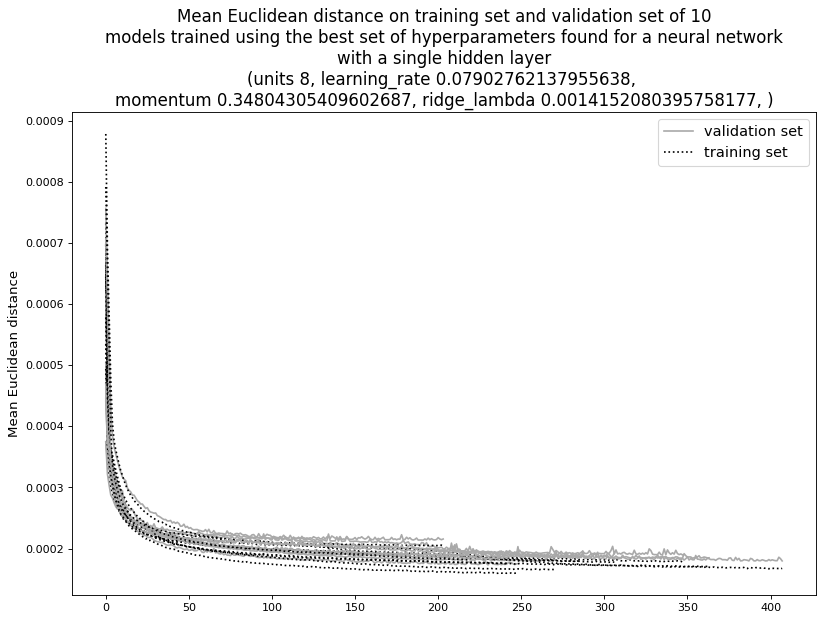

In [24]:
total_hp = 4
labels = ""
count = 1
for h_param in ["units", "learning_rate", "momentum", "ridge_lambda"]:
    labels += h_param + " " + str(best_hp2[0].get(h_param)) + ", "
    if(count % 2 == 0 and count != total_hp):
        labels += "\n"
    count += 1

list_values_val = [None]*n_trials
list_values_tr = [None]*n_trials

colours = ["darkgray", "black"]
linestyles = ["solid", "dotted"]

for i in range(n_trials):
    list_values_val[i] = hist[i].history['val_<lambda>']
    list_values_tr[i] = hist[i].history['<lambda>']
        
max_length = 0
for i in range(n_trials):
    if (max_length < len(list_values_tr[i])):
        max_length = len(list_values_tr[i])
        
time_ep = list(range(max_length))

plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values_val[i])], list_values_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values_tr[i])], list_values_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

legend = ["validation set", "training set"]

plt.title(
    "Mean Euclidean distance on training set and validation set of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with a single hidden layer\n("
    + labels + ")", size=15
)

plt.ylabel("Mean Euclidean distance", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/med_single_layer.png")
plt.show()

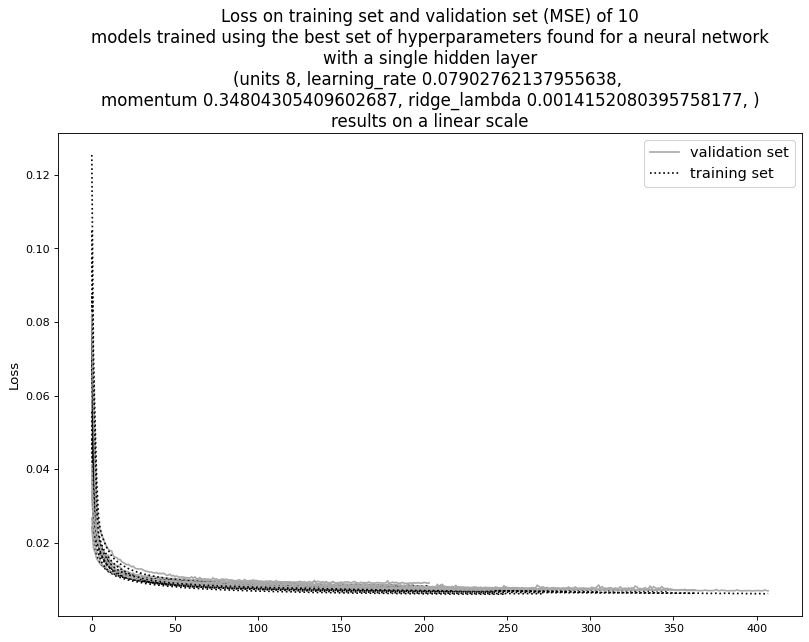

In [25]:
list_values2_val = [None]*n_trials
list_values2_tr = [None]*n_trials

for i in range(n_trials):
    list_values2_val[i] = hist[i].history['val_loss']
    list_values2_tr[i] = hist[i].history['loss']

plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values2_val[i])], list_values2_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values2_tr[i])], list_values2_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

plt.title(
    "Loss on training set and validation set (MSE) of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with a single hidden layer\n("
    + labels + ")\n" +
    "results on a linear scale", size=15
)

plt.ylabel("Loss", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/ms_loss_single_layer.png")
plt.show()

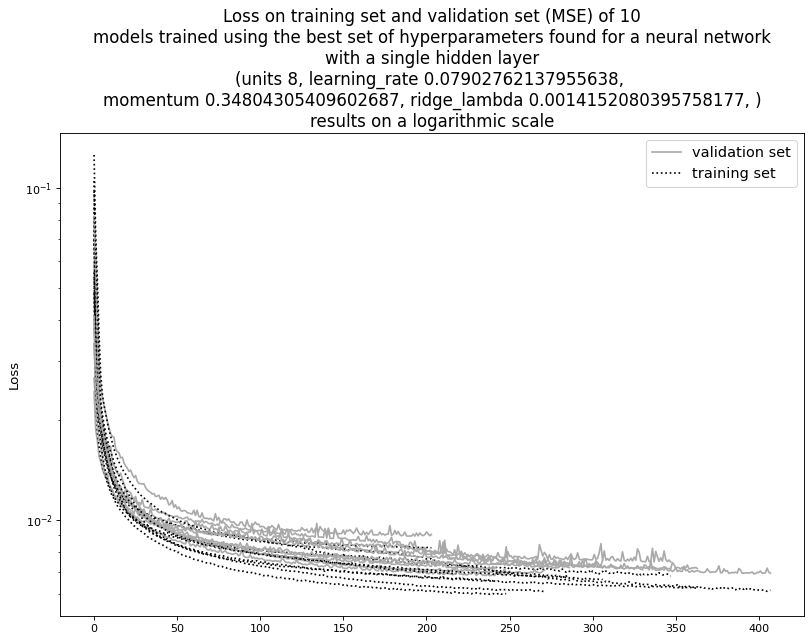

In [26]:
plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values2_val[i])], list_values2_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values2_tr[i])], list_values2_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

plt.title(
    "Loss on training set and validation set (MSE) of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with a single hidden layer\n("
    + labels + ")\n" +
    "results on a logarithmic scale", size=15
)

plt.ylabel("Loss", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/ms_loss_single_layer_log.png")
plt.yscale('log')
plt.show()

At this point we tried to add a second hidden layer to study whether its presence could help the neural network to generalise the problem.

Therefore we restarted the random search from scratch

In [27]:
# Restore the original training set
x_mlcup_tr = x_mlcup_ds
y_mlcup_tr = y_mlcup_ds

num_units_min = 2
num_units_max = 5
double_layer = True


# This lambda function has been used to specify the space of the hyperparameters that we want to explore
br_l = lambda a: build_regressor(
    a, my_metric=my_mean_euclidean_distance, min_units=num_units_min,
    max_units=num_units_max, double_layer=double_layer
)


tuner3 = CrossValidationRandomSearch(
    hypermodel=br_l, # function that return a model given a combination of hyperparameters
    objective=kt.Objective("val_<lambda>", direction="min"), # value to minimize
    max_trials=30, # maximum number of attempts
    executions_per_trial=2, # number of models created for each fold of the cross validation
    overwrite=True,
    directory="results/ml_cup",
    project_name="nn_RandomSearch/double_layer/first/par_hp",
    folds_number=3 # number of folds of the cross validation
)

print a brief description of the search space

In [28]:
tuner3.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': None}
ridge_lambda (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
learning_rate (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.6, 'step': None, 'sampling': 'log'}
momentum (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.9, 'step': None, 'sampling': 'linear'}


In [29]:
tuner3.search(
    # the training set for the model selection
    x_mlcup_tr, y_mlcup_tr,
    # maximum number of epochs allowed
    epochs=2500,
    # callback to implement early stopping
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)],
    shuffle=True
)

Trial 30 Complete [00h 01m 29s]
val_<lambda>: 0.00020609818117615455

Best val_<lambda> So Far: 0.00019542840406453857
Total elapsed time: 00h 19m 58s
INFO:tensorflow:Oracle triggered exit


In [30]:
best_hp3 = tuner3.get_best_hyperparameters(3)

print("results of the first random search with a double hidden layer\n")
for i in range(len(best_hp3)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "ridge_lambda", "learning_rate", "momentum"]:
        print(h_param, best_hp3[i].get(h_param))
    print("")

results of the first random search with a double hidden layer

best hyperparameters n. 0
units 4
ridge_lambda 0.00013985426941075848
learning_rate 0.062068467800480365
momentum 0.12273847799084353

best hyperparameters n. 1
units 4
ridge_lambda 0.000552117469490242
learning_rate 0.11539355385106059
momentum 0.08106901484055981

best hyperparameters n. 2
units 5
ridge_lambda 0.00011321948426331215
learning_rate 0.060965596011983106
momentum 0.5609144935248552



Brief description of the final neural network's structure

In [31]:
br_l = lambda a: build_regressor(
    a, my_metric=my_mean_euclidean_distance, double_layer=True
)

f_model3 = br_l(best_hp3[0])
f_model3.build(
input_shape=(None, 9))

f_model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 4)                 40        
                                                                 
 dense_4 (Dense)             (None, 4)                 20        
                                                                 
 dense_5 (Dense)             (None, 2)                 10        
                                                                 
Total params: 70
Trainable params: 70
Non-trainable params: 0
_________________________________________________________________


In [32]:
tuner3.results_summary()

Results summary
Results in results/ml_cup/nn_RandomSearch/double_layer/first/par_hp
Showing 10 best trials
Trial summary
Hyperparameters:
units: 4
ridge_lambda: 0.00013985426941075848
learning_rate: 0.062068467800480365
momentum: 0.12273847799084353
Score: 0.00019542840406453857
Trial summary
Hyperparameters:
units: 4
ridge_lambda: 0.000552117469490242
learning_rate: 0.11539355385106059
momentum: 0.08106901484055981
Score: 0.00019777588264939064
Trial summary
Hyperparameters:
units: 5
ridge_lambda: 0.00011321948426331215
learning_rate: 0.060965596011983106
momentum: 0.5609144935248552
Score: 0.00020609818117615455
Trial summary
Hyperparameters:
units: 4
ridge_lambda: 0.011560748678983452
learning_rate: 0.2125558531063482
momentum: 0.044545274362305834
Score: 0.00022704791869424903
Trial summary
Hyperparameters:
units: 4
ridge_lambda: 0.001851986779969056
learning_rate: 0.5055051336001027
momentum: 0.08033528943955663
Score: 0.00022886580457755676
Trial summary
Hyperparameters:
units: 4

Again, by now we have found a first best set of hyperparameters. We want to refine them by performing a second nested random search around this best combination of hyperparameters.

In [33]:
h_param = ["units", "ridge_lambda", "learning_rate", "momentum"]

num_units = best_hp3[0].get(h_param[0])
ridge_lambda = best_hp3[0].get(h_param[1])
learning_rate = best_hp3[0].get(h_param[2])
momentum = best_hp3[0].get(h_param[3])
double_layer = True

ridge_lambda_min = (ridge_lambda / 10) * 8
ridge_lambda_max = (ridge_lambda / 10) * 12

learning_rate_min = (learning_rate / 10) * 8
learning_rate_max = (learning_rate / 10) * 12

momentum_min = (momentum / 10) * 8
momentum_max = (momentum / 10) * 12

# This lambda function has been used to specify the space of the hyperparameters that we want to explore
br_l2 = lambda a: build_regressor(
    a, my_metric=my_mean_euclidean_distance, 
    min_units=num_units, max_units=num_units, min_ridge_lambda=ridge_lambda_min,
    max_ridge_lambda=ridge_lambda_max, min_lr_rate=learning_rate_min,
    max_lr_rate=learning_rate_max,min_mom=momentum_min, max_mom=momentum_max, linear_lr=True,
    linear_reg=True, double_layer=double_layer
)

tuner4 = CrossValidationRandomSearch(
    hypermodel=br_l2, # function which return a model given a combination of hyperparameters
    objective=kt.Objective("val_<lambda>", direction="min"), # value to minimize
    max_trials=30, # maximum number of attempts
    executions_per_trial=2, # models created for each fold of the cross validation
    overwrite=True,
    directory="results/ml_cup",
    project_name="nn_RandomSearch/double_layer/nested/par_hp",
    folds_number=3
)

Again, below there is a brief summary of the search space

In [34]:
tuner4.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 4, 'step': 1, 'sampling': None}
ridge_lambda (Float)
{'default': 0.00011188341552860679, 'conditions': [], 'min_value': 0.00011188341552860679, 'max_value': 0.0001678251232929102, 'step': None, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.049654774240384295, 'conditions': [], 'min_value': 0.049654774240384295, 'max_value': 0.07448216136057645, 'step': None, 'sampling': 'linear'}
momentum (Float)
{'default': 0.09819078239267483, 'conditions': [], 'min_value': 0.09819078239267483, 'max_value': 0.14728617358901225, 'step': None, 'sampling': 'linear'}


In [35]:
tuner4.search(
    x_mlcup_tr, y_mlcup_tr, # training set for the random search 
    epochs=2500, # maximum number of epochs allowed
    # callback to implement early stopping
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)],
    shuffle=True
)

Trial 30 Complete [00h 01m 39s]
val_<lambda>: 0.0003290597742307

Best val_<lambda> So Far: 0.00017958813017078987
Total elapsed time: 00h 49m 05s
INFO:tensorflow:Oracle triggered exit


Let's print again the best combination of hyperparameters found during this second nested random search with two hidden layers

In [36]:
best_hp4 = tuner4.get_best_hyperparameters(3)

print("results of the second nested random search with a single hidden layer\n")
for i in range(len(best_hp4)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "ridge_lambda", "learning_rate", "momentum"]:
        print(h_param, best_hp4[i].get(h_param))
    print("")

results of the second nested random search with a single hidden layer

best hyperparameters n. 0
units 4
ridge_lambda 0.00012028364969249436
learning_rate 0.059765148994962304
momentum 0.11572327849887087

best hyperparameters n. 1
units 4
ridge_lambda 0.00014517100290389946
learning_rate 0.05545864527427045
momentum 0.10964866300390042

best hyperparameters n. 2
units 4
ridge_lambda 0.00015803134698617977
learning_rate 0.05676696666531468
momentum 0.10997490298913094



Brief description of the final neural network's structure

In [37]:
br_l2 = lambda a: build_regressor(
    a, my_metric=my_mean_euclidean_distance, double_layer=True
)

f_model4 = br_l2(best_hp4[0])
f_model4.build(
input_shape=(None, 9))

f_model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 4)                 40        
                                                                 
 dense_4 (Dense)             (None, 4)                 20        
                                                                 
 dense_5 (Dense)             (None, 2)                 10        
                                                                 
Total params: 70
Trainable params: 70
Non-trainable params: 0
_________________________________________________________________


At this point we tried many neural networks using the best hyperparameters found by the second nested random search. Below we split the design set between training set and validation set. Remember that here we are using two hidden layers

In [38]:
subset_size = int(0.3 * len(x_mlcup_tr))

x_mlcup_ds = x_mlcup_tr
y_mlcup_ds = y_mlcup_tr

x_mlcup_vl = x_mlcup_ds[index]
y_mlcup_vl = y_mlcup_ds[index]

x_mlcup_tr = np.delete(x_mlcup_ds, index, 0)
y_mlcup_tr = np.delete(y_mlcup_ds, index, 0)

In [39]:
n_trials = 10

models2 = [None]*n_trials

for i in range(n_trials):
    models2[i] = br_l2(best_hp4[0])

n_epochs = 1000
hist2 = [None]*n_trials

for i in range(n_trials):
        hist2[i] = models2[i].fit(
            x=x_mlcup_tr,
            y=y_mlcup_tr,
            validation_data=(x_mlcup_vl, y_mlcup_vl),
            epochs=n_epochs,
            shuffle=True,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)]
        )

Epoch 1/1000
33/33 [==============================] - 1s 7ms/step - loss: 0.1456 - <lambda>: 9.2365e-04 - val_loss: 0.0616 - val_<lambda>: 6.4878e-04
Epoch 2/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0493 - <lambda>: 5.7557e-04 - val_loss: 0.0425 - val_<lambda>: 5.4599e-04
Epoch 3/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0386 - <lambda>: 5.1590e-04 - val_loss: 0.0349 - val_<lambda>: 4.9659e-04
Epoch 4/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0322 - <lambda>: 4.7291e-04 - val_loss: 0.0291 - val_<lambda>: 4.4919e-04
Epoch 5/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0276 - <lambda>: 4.3490e-04 - val_loss: 0.0251 - val_<lambda>: 4.1466e-04
Epoch 6/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0242 - <lambda>: 4.0558e-04 - val_loss: 0.0227 - val_<lambda>: 3.9567e-04
Epoch 7/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0216 - <lambda>: 3.8250e

33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 2.0727e-04 - val_loss: 0.0082 - val_<lambda>: 2.1571e-04
Epoch 110/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 2.0722e-04 - val_loss: 0.0081 - val_<lambda>: 2.1361e-04
Epoch 111/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 2.0689e-04 - val_loss: 0.0080 - val_<lambda>: 2.1270e-04
Epoch 112/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 2.0652e-04 - val_loss: 0.0082 - val_<lambda>: 2.1588e-04
Epoch 113/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 2.0679e-04 - val_loss: 0.0081 - val_<lambda>: 2.1319e-04
Epoch 114/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 2.0673e-04 - val_loss: 0.0080 - val_<lambda>: 2.1245e-04
Epoch 115/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 2.0612e-

Epoch 163/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0072 - <lambda>: 2.0005e-04 - val_loss: 0.0076 - val_<lambda>: 2.0671e-04
Epoch 164/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0073 - <lambda>: 1.9943e-04 - val_loss: 0.0077 - val_<lambda>: 2.0834e-04
Epoch 165/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0072 - <lambda>: 2.0022e-04 - val_loss: 0.0078 - val_<lambda>: 2.0977e-04
Epoch 166/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0072 - <lambda>: 1.9977e-04 - val_loss: 0.0076 - val_<lambda>: 2.0568e-04
Epoch 167/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0072 - <lambda>: 1.9963e-04 - val_loss: 0.0078 - val_<lambda>: 2.1010e-04
Epoch 168/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0072 - <lambda>: 1.9997e-04 - val_loss: 0.0076 - val_<lambda>: 2.0587e-04
Epoch 169/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0072 - <la

Epoch 217/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0070 - <lambda>: 1.9544e-04 - val_loss: 0.0074 - val_<lambda>: 2.0255e-04
Epoch 218/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0070 - <lambda>: 1.9499e-04 - val_loss: 0.0073 - val_<lambda>: 2.0130e-04
Epoch 219/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0070 - <lambda>: 1.9563e-04 - val_loss: 0.0074 - val_<lambda>: 2.0263e-04
Epoch 220/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0070 - <lambda>: 1.9503e-04 - val_loss: 0.0074 - val_<lambda>: 2.0271e-04
Epoch 221/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0070 - <lambda>: 1.9494e-04 - val_loss: 0.0074 - val_<lambda>: 2.0277e-04
Epoch 222/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0070 - <lambda>: 1.9469e-04 - val_loss: 0.0073 - val_<lambda>: 2.0108e-04
Epoch 223/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0070 - <la

Epoch 271/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0068 - <lambda>: 1.9197e-04 - val_loss: 0.0072 - val_<lambda>: 1.9857e-04
Epoch 272/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0068 - <lambda>: 1.9193e-04 - val_loss: 0.0072 - val_<lambda>: 1.9862e-04
Epoch 273/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0067 - <lambda>: 1.9130e-04 - val_loss: 0.0075 - val_<lambda>: 2.0532e-04
Epoch 274/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0068 - <lambda>: 1.9175e-04 - val_loss: 0.0072 - val_<lambda>: 1.9941e-04
Epoch 275/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0068 - <lambda>: 1.9129e-04 - val_loss: 0.0072 - val_<lambda>: 1.9847e-04
Epoch 276/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0068 - <lambda>: 1.9157e-04 - val_loss: 0.0073 - val_<lambda>: 2.0285e-04
Epoch 277/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0068 - <la

Epoch 325/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <lambda>: 1.8889e-04 - val_loss: 0.0070 - val_<lambda>: 1.9619e-04
Epoch 326/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <lambda>: 1.8832e-04 - val_loss: 0.0070 - val_<lambda>: 1.9581e-04
Epoch 327/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <lambda>: 1.8860e-04 - val_loss: 0.0070 - val_<lambda>: 1.9539e-04
Epoch 328/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <lambda>: 1.8798e-04 - val_loss: 0.0070 - val_<lambda>: 1.9611e-04
Epoch 329/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <lambda>: 1.8868e-04 - val_loss: 0.0071 - val_<lambda>: 1.9845e-04
Epoch 330/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <lambda>: 1.8784e-04 - val_loss: 0.0070 - val_<lambda>: 1.9675e-04
Epoch 331/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <la

33/33 [==============================] - 0s 2ms/step - loss: 0.0204 - <lambda>: 3.6564e-04 - val_loss: 0.0204 - val_<lambda>: 3.5887e-04
Epoch 11/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0203 - <lambda>: 3.6393e-04 - val_loss: 0.0203 - val_<lambda>: 3.6046e-04
Epoch 12/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0202 - <lambda>: 3.6280e-04 - val_loss: 0.0206 - val_<lambda>: 3.6715e-04
Epoch 13/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0201 - <lambda>: 3.6227e-04 - val_loss: 0.0201 - val_<lambda>: 3.6106e-04
Epoch 14/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0200 - <lambda>: 3.6184e-04 - val_loss: 0.0200 - val_<lambda>: 3.5611e-04
Epoch 15/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0200 - <lambda>: 3.6123e-04 - val_loss: 0.0199 - val_<lambda>: 3.5787e-04
Epoch 16/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0199 - <lambda>: 3.6020e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0217 - <lambda>: 3.7781e-04 - val_loss: 0.0210 - val_<lambda>: 3.6420e-04
Epoch 14/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0215 - <lambda>: 3.7735e-04 - val_loss: 0.0210 - val_<lambda>: 3.6373e-04
Epoch 15/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0215 - <lambda>: 3.7645e-04 - val_loss: 0.0210 - val_<lambda>: 3.6506e-04
Epoch 16/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0214 - <lambda>: 3.7591e-04 - val_loss: 0.0207 - val_<lambda>: 3.6300e-04
Epoch 17/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0213 - <lambda>: 3.7558e-04 - val_loss: 0.0208 - val_<lambda>: 3.6358e-04
Epoch 18/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0212 - <lambda>: 3.7498e-04 - val_loss: 0.0207 - val_<lambda>: 3.6245e-04
Epoch 19/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0212 - <lambda>: 3.7401e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0102 - <lambda>: 2.4367e-04 - val_loss: 0.0106 - val_<lambda>: 2.4442e-04
Epoch 122/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0101 - <lambda>: 2.4188e-04 - val_loss: 0.0104 - val_<lambda>: 2.4125e-04
Epoch 123/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0099 - <lambda>: 2.3858e-04 - val_loss: 0.0103 - val_<lambda>: 2.4042e-04
Epoch 124/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0097 - <lambda>: 2.3680e-04 - val_loss: 0.0101 - val_<lambda>: 2.3618e-04
Epoch 125/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0096 - <lambda>: 2.3422e-04 - val_loss: 0.0100 - val_<lambda>: 2.3378e-04
Epoch 126/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0095 - <lambda>: 2.3136e-04 - val_loss: 0.0099 - val_<lambda>: 2.3599e-04
Epoch 127/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0093 - <lambda>: 2.3039e-

Epoch 175/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 2.0390e-04 - val_loss: 0.0080 - val_<lambda>: 2.0595e-04
Epoch 176/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 2.0303e-04 - val_loss: 0.0080 - val_<lambda>: 2.0720e-04
Epoch 177/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 2.0315e-04 - val_loss: 0.0081 - val_<lambda>: 2.0697e-04
Epoch 178/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 2.0229e-04 - val_loss: 0.0081 - val_<lambda>: 2.0796e-04
Epoch 179/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 2.0299e-04 - val_loss: 0.0079 - val_<lambda>: 2.0524e-04
Epoch 180/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 2.0236e-04 - val_loss: 0.0080 - val_<lambda>: 2.0609e-04
Epoch 181/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <la

Epoch 229/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0067 - <lambda>: 1.8890e-04 - val_loss: 0.0072 - val_<lambda>: 1.9212e-04
Epoch 230/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0067 - <lambda>: 1.8898e-04 - val_loss: 0.0072 - val_<lambda>: 1.9158e-04
Epoch 231/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0067 - <lambda>: 1.8876e-04 - val_loss: 0.0072 - val_<lambda>: 1.9130e-04
Epoch 232/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0067 - <lambda>: 1.8839e-04 - val_loss: 0.0073 - val_<lambda>: 1.9372e-04
Epoch 233/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0067 - <lambda>: 1.8849e-04 - val_loss: 0.0071 - val_<lambda>: 1.9101e-04
Epoch 234/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0067 - <lambda>: 1.8823e-04 - val_loss: 0.0071 - val_<lambda>: 1.9008e-04
Epoch 235/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0067 - <la

Epoch 283/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0062 - <lambda>: 1.7992e-04 - val_loss: 0.0067 - val_<lambda>: 1.8452e-04
Epoch 284/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0062 - <lambda>: 1.7969e-04 - val_loss: 0.0066 - val_<lambda>: 1.8341e-04
Epoch 285/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0062 - <lambda>: 1.7975e-04 - val_loss: 0.0067 - val_<lambda>: 1.8391e-04
Epoch 286/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0062 - <lambda>: 1.7957e-04 - val_loss: 0.0067 - val_<lambda>: 1.8380e-04
Epoch 287/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0062 - <lambda>: 1.7974e-04 - val_loss: 0.0066 - val_<lambda>: 1.8354e-04
Epoch 288/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0062 - <lambda>: 1.7945e-04 - val_loss: 0.0066 - val_<lambda>: 1.8373e-04
Epoch 289/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0062 - <la

Epoch 337/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0059 - <lambda>: 1.7414e-04 - val_loss: 0.0064 - val_<lambda>: 1.7972e-04
Epoch 338/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0059 - <lambda>: 1.7345e-04 - val_loss: 0.0064 - val_<lambda>: 1.7963e-04
Epoch 339/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0059 - <lambda>: 1.7409e-04 - val_loss: 0.0064 - val_<lambda>: 1.8032e-04
Epoch 340/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0059 - <lambda>: 1.7408e-04 - val_loss: 0.0065 - val_<lambda>: 1.8102e-04
Epoch 341/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0059 - <lambda>: 1.7409e-04 - val_loss: 0.0064 - val_<lambda>: 1.8005e-04
Epoch 342/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0058 - <lambda>: 1.7365e-04 - val_loss: 0.0064 - val_<lambda>: 1.8058e-04
Epoch 343/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0059 - <la

33/33 [==============================] - 0s 2ms/step - loss: 0.0097 - <lambda>: 2.3933e-04 - val_loss: 0.0100 - val_<lambda>: 2.4285e-04
Epoch 63/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0097 - <lambda>: 2.3896e-04 - val_loss: 0.0097 - val_<lambda>: 2.3878e-04
Epoch 64/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0096 - <lambda>: 2.3847e-04 - val_loss: 0.0098 - val_<lambda>: 2.4070e-04
Epoch 65/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0096 - <lambda>: 2.3757e-04 - val_loss: 0.0097 - val_<lambda>: 2.3957e-04
Epoch 66/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0095 - <lambda>: 2.3712e-04 - val_loss: 0.0098 - val_<lambda>: 2.4072e-04
Epoch 67/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0095 - <lambda>: 2.3641e-04 - val_loss: 0.0097 - val_<lambda>: 2.4031e-04
Epoch 68/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0094 - <lambda>: 2.3559e-04 - v

Epoch 170/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 2.0373e-04 - val_loss: 0.0076 - val_<lambda>: 2.0788e-04
Epoch 171/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 2.0433e-04 - val_loss: 0.0076 - val_<lambda>: 2.0661e-04
Epoch 172/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 2.0370e-04 - val_loss: 0.0076 - val_<lambda>: 2.0843e-04
Epoch 173/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 2.0353e-04 - val_loss: 0.0078 - val_<lambda>: 2.1140e-04
Epoch 174/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 2.0384e-04 - val_loss: 0.0076 - val_<lambda>: 2.0848e-04
Epoch 175/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0073 - <lambda>: 2.0373e-04 - val_loss: 0.0077 - val_<lambda>: 2.0813e-04
Epoch 176/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <la

Epoch 224/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0071 - <lambda>: 1.9962e-04 - val_loss: 0.0075 - val_<lambda>: 2.0599e-04
Epoch 225/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0071 - <lambda>: 1.9956e-04 - val_loss: 0.0074 - val_<lambda>: 2.0425e-04
Epoch 226/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0071 - <lambda>: 1.9919e-04 - val_loss: 0.0074 - val_<lambda>: 2.0346e-04
Epoch 227/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0071 - <lambda>: 1.9894e-04 - val_loss: 0.0075 - val_<lambda>: 2.0609e-04
Epoch 228/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0071 - <lambda>: 1.9945e-04 - val_loss: 0.0074 - val_<lambda>: 2.0385e-04
Epoch 229/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0071 - <lambda>: 1.9927e-04 - val_loss: 0.0074 - val_<lambda>: 2.0575e-04
Epoch 230/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0071 - <la

Epoch 8/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0228 - <lambda>: 3.7215e-04 - val_loss: 0.0209 - val_<lambda>: 3.4165e-04
Epoch 9/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0203 - <lambda>: 3.4736e-04 - val_loss: 0.0188 - val_<lambda>: 3.2336e-04
Epoch 10/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0185 - <lambda>: 3.2996e-04 - val_loss: 0.0177 - val_<lambda>: 3.0621e-04
Epoch 11/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0172 - <lambda>: 3.1453e-04 - val_loss: 0.0162 - val_<lambda>: 3.0152e-04
Epoch 12/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0161 - <lambda>: 3.0384e-04 - val_loss: 0.0155 - val_<lambda>: 2.9222e-04
Epoch 13/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0152 - <lambda>: 2.9415e-04 - val_loss: 0.0148 - val_<lambda>: 2.8541e-04
Epoch 14/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0145 - <lambda>: 2.

33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 2.0113e-04 - val_loss: 0.0081 - val_<lambda>: 2.0466e-04
Epoch 117/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 2.0036e-04 - val_loss: 0.0081 - val_<lambda>: 2.0544e-04
Epoch 118/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 2.0034e-04 - val_loss: 0.0080 - val_<lambda>: 2.0145e-04
Epoch 119/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 2.0033e-04 - val_loss: 0.0080 - val_<lambda>: 2.0384e-04
Epoch 120/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.9963e-04 - val_loss: 0.0079 - val_<lambda>: 2.0109e-04
Epoch 121/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 2.0021e-04 - val_loss: 0.0080 - val_<lambda>: 2.0161e-04
Epoch 122/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 1.9891e-

Epoch 170/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0070 - <lambda>: 1.9015e-04 - val_loss: 0.0074 - val_<lambda>: 1.9319e-04
Epoch 171/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0070 - <lambda>: 1.9008e-04 - val_loss: 0.0075 - val_<lambda>: 1.9339e-04
Epoch 172/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0070 - <lambda>: 1.9066e-04 - val_loss: 0.0074 - val_<lambda>: 1.9418e-04
Epoch 173/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0070 - <lambda>: 1.8970e-04 - val_loss: 0.0074 - val_<lambda>: 1.9386e-04
Epoch 174/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0070 - <lambda>: 1.8996e-04 - val_loss: 0.0074 - val_<lambda>: 1.9332e-04
Epoch 175/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0070 - <lambda>: 1.8960e-04 - val_loss: 0.0074 - val_<lambda>: 1.9367e-04
Epoch 176/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0069 - <la

Epoch 224/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <lambda>: 1.8362e-04 - val_loss: 0.0070 - val_<lambda>: 1.8866e-04
Epoch 225/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <lambda>: 1.8299e-04 - val_loss: 0.0070 - val_<lambda>: 1.8828e-04
Epoch 226/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0065 - <lambda>: 1.8281e-04 - val_loss: 0.0070 - val_<lambda>: 1.8763e-04
Epoch 227/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <lambda>: 1.8297e-04 - val_loss: 0.0070 - val_<lambda>: 1.8825e-04
Epoch 228/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0065 - <lambda>: 1.8230e-04 - val_loss: 0.0070 - val_<lambda>: 1.8727e-04
Epoch 229/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0065 - <lambda>: 1.8282e-04 - val_loss: 0.0069 - val_<lambda>: 1.8691e-04
Epoch 230/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0065 - <la

Epoch 278/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0062 - <lambda>: 1.7745e-04 - val_loss: 0.0068 - val_<lambda>: 1.8488e-04
Epoch 279/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0062 - <lambda>: 1.7702e-04 - val_loss: 0.0067 - val_<lambda>: 1.8411e-04
Epoch 280/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0063 - <lambda>: 1.7804e-04 - val_loss: 0.0067 - val_<lambda>: 1.8448e-04
Epoch 281/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0062 - <lambda>: 1.7764e-04 - val_loss: 0.0067 - val_<lambda>: 1.8384e-04
Epoch 282/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0062 - <lambda>: 1.7753e-04 - val_loss: 0.0067 - val_<lambda>: 1.8431e-04
Epoch 283/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0062 - <lambda>: 1.7699e-04 - val_loss: 0.0067 - val_<lambda>: 1.8534e-04
Epoch 284/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0062 - <la

Epoch 332/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0060 - <lambda>: 1.7412e-04 - val_loss: 0.0065 - val_<lambda>: 1.8174e-04
Epoch 333/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0060 - <lambda>: 1.7385e-04 - val_loss: 0.0065 - val_<lambda>: 1.8127e-04
Epoch 334/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0060 - <lambda>: 1.7335e-04 - val_loss: 0.0065 - val_<lambda>: 1.8176e-04
Epoch 335/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0060 - <lambda>: 1.7369e-04 - val_loss: 0.0065 - val_<lambda>: 1.8144e-04
Epoch 336/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0060 - <lambda>: 1.7360e-04 - val_loss: 0.0066 - val_<lambda>: 1.8256e-04
Epoch 337/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0060 - <lambda>: 1.7352e-04 - val_loss: 0.0065 - val_<lambda>: 1.8202e-04
Epoch 338/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0060 - <la

Epoch 386/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0058 - <lambda>: 1.7092e-04 - val_loss: 0.0064 - val_<lambda>: 1.8121e-04
Epoch 387/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0058 - <lambda>: 1.7130e-04 - val_loss: 0.0064 - val_<lambda>: 1.8032e-04
Epoch 388/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0058 - <lambda>: 1.7050e-04 - val_loss: 0.0064 - val_<lambda>: 1.8023e-04
Epoch 389/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0058 - <lambda>: 1.7067e-04 - val_loss: 0.0065 - val_<lambda>: 1.8278e-04
Epoch 390/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0058 - <lambda>: 1.7134e-04 - val_loss: 0.0064 - val_<lambda>: 1.8041e-04
Epoch 391/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0058 - <lambda>: 1.7097e-04 - val_loss: 0.0064 - val_<lambda>: 1.8028e-04
Epoch 392/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0058 - <la

33/33 [==============================] - 0s 2ms/step - loss: 0.0144 - <lambda>: 2.9281e-04 - val_loss: 0.0147 - val_<lambda>: 2.9038e-04
Epoch 19/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0141 - <lambda>: 2.8999e-04 - val_loss: 0.0145 - val_<lambda>: 2.8714e-04
Epoch 20/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0139 - <lambda>: 2.8652e-04 - val_loss: 0.0143 - val_<lambda>: 2.8437e-04
Epoch 21/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0136 - <lambda>: 2.8325e-04 - val_loss: 0.0141 - val_<lambda>: 2.8161e-04
Epoch 22/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0134 - <lambda>: 2.7977e-04 - val_loss: 0.0140 - val_<lambda>: 2.8040e-04
Epoch 23/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0132 - <lambda>: 2.7713e-04 - val_loss: 0.0138 - val_<lambda>: 2.7792e-04
Epoch 24/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0129 - <lambda>: 2.7389e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 2.0082e-04 - val_loss: 0.0085 - val_<lambda>: 2.1044e-04
Epoch 127/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 2.0008e-04 - val_loss: 0.0085 - val_<lambda>: 2.0913e-04
Epoch 128/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.9962e-04 - val_loss: 0.0086 - val_<lambda>: 2.1119e-04
Epoch 129/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 2.0009e-04 - val_loss: 0.0085 - val_<lambda>: 2.0984e-04
Epoch 130/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.9955e-04 - val_loss: 0.0085 - val_<lambda>: 2.0989e-04
Epoch 131/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 1.9939e-04 - val_loss: 0.0086 - val_<lambda>: 2.1060e-04
Epoch 132/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 1.9894e-

Epoch 180/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0070 - <lambda>: 1.9120e-04 - val_loss: 0.0078 - val_<lambda>: 2.0249e-04
Epoch 181/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0069 - <lambda>: 1.9120e-04 - val_loss: 0.0078 - val_<lambda>: 2.0141e-04
Epoch 182/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0069 - <lambda>: 1.9037e-04 - val_loss: 0.0079 - val_<lambda>: 2.0244e-04
Epoch 183/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0069 - <lambda>: 1.9111e-04 - val_loss: 0.0079 - val_<lambda>: 2.0248e-04
Epoch 184/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0070 - <lambda>: 1.9107e-04 - val_loss: 0.0078 - val_<lambda>: 2.0111e-04
Epoch 185/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0069 - <lambda>: 1.9070e-04 - val_loss: 0.0078 - val_<lambda>: 2.0187e-04
Epoch 186/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0069 - <la

Epoch 234/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <lambda>: 1.8638e-04 - val_loss: 0.0074 - val_<lambda>: 1.9778e-04
Epoch 235/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <lambda>: 1.8582e-04 - val_loss: 0.0075 - val_<lambda>: 1.9794e-04
Epoch 236/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <lambda>: 1.8593e-04 - val_loss: 0.0075 - val_<lambda>: 1.9763e-04
Epoch 237/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <lambda>: 1.8536e-04 - val_loss: 0.0074 - val_<lambda>: 1.9737e-04
Epoch 238/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <lambda>: 1.8573e-04 - val_loss: 0.0074 - val_<lambda>: 1.9781e-04
Epoch 239/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <lambda>: 1.8609e-04 - val_loss: 0.0074 - val_<lambda>: 1.9777e-04
Epoch 240/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - <la

Epoch 288/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0064 - <lambda>: 1.8262e-04 - val_loss: 0.0072 - val_<lambda>: 1.9419e-04
Epoch 289/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0063 - <lambda>: 1.8187e-04 - val_loss: 0.0072 - val_<lambda>: 1.9510e-04
Epoch 290/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0063 - <lambda>: 1.8234e-04 - val_loss: 0.0072 - val_<lambda>: 1.9450e-04
Epoch 291/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0063 - <lambda>: 1.8261e-04 - val_loss: 0.0072 - val_<lambda>: 1.9438e-04
Epoch 292/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0063 - <lambda>: 1.8257e-04 - val_loss: 0.0072 - val_<lambda>: 1.9420e-04
Epoch 293/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0063 - <lambda>: 1.8267e-04 - val_loss: 0.0071 - val_<lambda>: 1.9405e-04
Epoch 294/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0063 - <la

Epoch 342/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0062 - <lambda>: 1.7964e-04 - val_loss: 0.0069 - val_<lambda>: 1.9191e-04
Epoch 343/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0061 - <lambda>: 1.7967e-04 - val_loss: 0.0069 - val_<lambda>: 1.9166e-04
Epoch 344/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0061 - <lambda>: 1.7921e-04 - val_loss: 0.0069 - val_<lambda>: 1.9191e-04
Epoch 345/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0061 - <lambda>: 1.7912e-04 - val_loss: 0.0070 - val_<lambda>: 1.9234e-04
Epoch 346/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0061 - <lambda>: 1.7908e-04 - val_loss: 0.0069 - val_<lambda>: 1.9118e-04
Epoch 347/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0061 - <lambda>: 1.7932e-04 - val_loss: 0.0069 - val_<lambda>: 1.9108e-04
Epoch 348/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0061 - <la

Epoch 396/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0060 - <lambda>: 1.7709e-04 - val_loss: 0.0068 - val_<lambda>: 1.8944e-04
Epoch 397/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0060 - <lambda>: 1.7712e-04 - val_loss: 0.0068 - val_<lambda>: 1.8932e-04
Epoch 398/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0059 - <lambda>: 1.7737e-04 - val_loss: 0.0068 - val_<lambda>: 1.9089e-04
Epoch 399/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0060 - <lambda>: 1.7684e-04 - val_loss: 0.0068 - val_<lambda>: 1.9039e-04
Epoch 400/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0060 - <lambda>: 1.7710e-04 - val_loss: 0.0067 - val_<lambda>: 1.8930e-04
Epoch 401/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0059 - <lambda>: 1.7678e-04 - val_loss: 0.0067 - val_<lambda>: 1.8913e-04
Epoch 402/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0060 - <la

Epoch 450/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0058 - <lambda>: 1.7534e-04 - val_loss: 0.0066 - val_<lambda>: 1.8790e-04
Epoch 451/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0058 - <lambda>: 1.7466e-04 - val_loss: 0.0067 - val_<lambda>: 1.8920e-04
Epoch 452/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0058 - <lambda>: 1.7464e-04 - val_loss: 0.0067 - val_<lambda>: 1.8793e-04
Epoch 453/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0058 - <lambda>: 1.7420e-04 - val_loss: 0.0067 - val_<lambda>: 1.8805e-04
Epoch 454/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0058 - <lambda>: 1.7534e-04 - val_loss: 0.0066 - val_<lambda>: 1.8733e-04
Epoch 455/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0058 - <lambda>: 1.7481e-04 - val_loss: 0.0066 - val_<lambda>: 1.8739e-04
Epoch 456/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0058 - <la

Epoch 504/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0057 - <lambda>: 1.7367e-04 - val_loss: 0.0066 - val_<lambda>: 1.8772e-04
Epoch 505/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0057 - <lambda>: 1.7336e-04 - val_loss: 0.0065 - val_<lambda>: 1.8648e-04
Epoch 506/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0057 - <lambda>: 1.7330e-04 - val_loss: 0.0065 - val_<lambda>: 1.8630e-04
Epoch 507/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0057 - <lambda>: 1.7275e-04 - val_loss: 0.0065 - val_<lambda>: 1.8636e-04
Epoch 508/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0057 - <lambda>: 1.7351e-04 - val_loss: 0.0065 - val_<lambda>: 1.8609e-04
Epoch 509/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0057 - <lambda>: 1.7315e-04 - val_loss: 0.0065 - val_<lambda>: 1.8655e-04
Epoch 510/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0057 - <la

Epoch 558/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0056 - <lambda>: 1.7148e-04 - val_loss: 0.0065 - val_<lambda>: 1.8515e-04
Epoch 559/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0056 - <lambda>: 1.7184e-04 - val_loss: 0.0064 - val_<lambda>: 1.8514e-04
Epoch 560/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0056 - <lambda>: 1.7143e-04 - val_loss: 0.0064 - val_<lambda>: 1.8490e-04
Epoch 561/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0056 - <lambda>: 1.7124e-04 - val_loss: 0.0065 - val_<lambda>: 1.8667e-04
Epoch 562/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0056 - <lambda>: 1.7136e-04 - val_loss: 0.0065 - val_<lambda>: 1.8623e-04
Epoch 563/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0057 - <lambda>: 1.7176e-04 - val_loss: 0.0064 - val_<lambda>: 1.8453e-04
Epoch 564/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0056 - <la

33/33 [==============================] - 0s 2ms/step - loss: 0.0088 - <lambda>: 2.2235e-04 - val_loss: 0.0091 - val_<lambda>: 2.2692e-04
Epoch 80/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0088 - <lambda>: 2.2218e-04 - val_loss: 0.0093 - val_<lambda>: 2.3018e-04
Epoch 81/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0087 - <lambda>: 2.2168e-04 - val_loss: 0.0091 - val_<lambda>: 2.2630e-04
Epoch 82/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0087 - <lambda>: 2.2173e-04 - val_loss: 0.0093 - val_<lambda>: 2.2950e-04
Epoch 83/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0087 - <lambda>: 2.2090e-04 - val_loss: 0.0092 - val_<lambda>: 2.2958e-04
Epoch 84/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - <lambda>: 2.2079e-04 - val_loss: 0.0092 - val_<lambda>: 2.2785e-04
Epoch 85/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0087 - <lambda>: 2.2173e-04 - v

Epoch 187/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 2.0796e-04 - val_loss: 0.0081 - val_<lambda>: 2.1198e-04
Epoch 188/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 2.0749e-04 - val_loss: 0.0081 - val_<lambda>: 2.1229e-04
Epoch 189/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 2.0762e-04 - val_loss: 0.0081 - val_<lambda>: 2.1209e-04
Epoch 190/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 2.0732e-04 - val_loss: 0.0081 - val_<lambda>: 2.1190e-04
Epoch 191/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 2.0797e-04 - val_loss: 0.0082 - val_<lambda>: 2.1319e-04
Epoch 192/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 2.0789e-04 - val_loss: 0.0083 - val_<lambda>: 2.1595e-04
Epoch 193/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <la

Epoch 241/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 2.0378e-04 - val_loss: 0.0079 - val_<lambda>: 2.0913e-04
Epoch 242/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 2.0522e-04 - val_loss: 0.0080 - val_<lambda>: 2.1134e-04
Epoch 243/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 2.0429e-04 - val_loss: 0.0082 - val_<lambda>: 2.1507e-04
Epoch 244/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 2.0393e-04 - val_loss: 0.0078 - val_<lambda>: 2.0799e-04
Epoch 245/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 2.0370e-04 - val_loss: 0.0079 - val_<lambda>: 2.0835e-04
Epoch 246/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 2.0415e-04 - val_loss: 0.0079 - val_<lambda>: 2.1028e-04
Epoch 247/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <la

33/33 [==============================] - 0s 2ms/step - loss: 0.0112 - <lambda>: 2.5046e-04 - val_loss: 0.0121 - val_<lambda>: 2.5451e-04
Epoch 96/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0111 - <lambda>: 2.4947e-04 - val_loss: 0.0121 - val_<lambda>: 2.5437e-04
Epoch 97/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0110 - <lambda>: 2.4807e-04 - val_loss: 0.0120 - val_<lambda>: 2.5362e-04
Epoch 98/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0110 - <lambda>: 2.4799e-04 - val_loss: 0.0119 - val_<lambda>: 2.5070e-04
Epoch 99/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0109 - <lambda>: 2.4632e-04 - val_loss: 0.0119 - val_<lambda>: 2.5063e-04
Epoch 100/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0108 - <lambda>: 2.4539e-04 - val_loss: 0.0118 - val_<lambda>: 2.4932e-04
Epoch 101/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0108 - <lambda>: 2.4516e-04 -

33/33 [==============================] - 0s 2ms/step - loss: 0.0093 - <lambda>: 2.2485e-04 - val_loss: 0.0104 - val_<lambda>: 2.3142e-04
Epoch 150/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0092 - <lambda>: 2.2400e-04 - val_loss: 0.0106 - val_<lambda>: 2.3381e-04
Epoch 151/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0093 - <lambda>: 2.2385e-04 - val_loss: 0.0104 - val_<lambda>: 2.3316e-04
Epoch 152/1000
33/33 [==============================] - 0s 3ms/step - loss: 0.0093 - <lambda>: 2.2489e-04 - val_loss: 0.0103 - val_<lambda>: 2.3122e-04
Epoch 153/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0092 - <lambda>: 2.2400e-04 - val_loss: 0.0104 - val_<lambda>: 2.3318e-04
Epoch 154/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0092 - <lambda>: 2.2332e-04 - val_loss: 0.0103 - val_<lambda>: 2.3262e-04
Epoch 155/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0092 - <lambda>: 2.2384e-

Epoch 203/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0084 - <lambda>: 2.1488e-04 - val_loss: 0.0095 - val_<lambda>: 2.2359e-04
Epoch 204/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - <lambda>: 2.1480e-04 - val_loss: 0.0095 - val_<lambda>: 2.2368e-04
Epoch 205/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - <lambda>: 2.1504e-04 - val_loss: 0.0097 - val_<lambda>: 2.2716e-04
Epoch 206/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0084 - <lambda>: 2.1410e-04 - val_loss: 0.0094 - val_<lambda>: 2.2347e-04
Epoch 207/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0084 - <lambda>: 2.1375e-04 - val_loss: 0.0094 - val_<lambda>: 2.2343e-04
Epoch 208/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0084 - <lambda>: 2.1325e-04 - val_loss: 0.0094 - val_<lambda>: 2.2347e-04
Epoch 209/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0084 - <la

Epoch 257/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 2.0283e-04 - val_loss: 0.0084 - val_<lambda>: 2.1206e-04
Epoch 258/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 2.0213e-04 - val_loss: 0.0083 - val_<lambda>: 2.1096e-04
Epoch 259/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 2.0249e-04 - val_loss: 0.0083 - val_<lambda>: 2.1085e-04
Epoch 260/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 2.0213e-04 - val_loss: 0.0083 - val_<lambda>: 2.1096e-04
Epoch 261/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 2.0219e-04 - val_loss: 0.0083 - val_<lambda>: 2.1165e-04
Epoch 262/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 2.0120e-04 - val_loss: 0.0083 - val_<lambda>: 2.1079e-04
Epoch 263/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <la

Epoch 311/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0071 - <lambda>: 1.9615e-04 - val_loss: 0.0077 - val_<lambda>: 2.0367e-04
Epoch 312/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0070 - <lambda>: 1.9523e-04 - val_loss: 0.0077 - val_<lambda>: 2.0331e-04
Epoch 313/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0070 - <lambda>: 1.9504e-04 - val_loss: 0.0077 - val_<lambda>: 2.0533e-04
Epoch 314/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0070 - <lambda>: 1.9543e-04 - val_loss: 0.0076 - val_<lambda>: 2.0292e-04
Epoch 315/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0070 - <lambda>: 1.9460e-04 - val_loss: 0.0076 - val_<lambda>: 2.0288e-04
Epoch 316/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0070 - <lambda>: 1.9576e-04 - val_loss: 0.0077 - val_<lambda>: 2.0364e-04
Epoch 317/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0070 - <la

Epoch 365/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0067 - <lambda>: 1.9096e-04 - val_loss: 0.0075 - val_<lambda>: 2.0421e-04
Epoch 366/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0067 - <lambda>: 1.9097e-04 - val_loss: 0.0074 - val_<lambda>: 2.0163e-04
Epoch 367/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0067 - <lambda>: 1.9050e-04 - val_loss: 0.0074 - val_<lambda>: 1.9971e-04
Epoch 368/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0068 - <lambda>: 1.9177e-04 - val_loss: 0.0073 - val_<lambda>: 1.9926e-04
Epoch 369/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0067 - <lambda>: 1.9062e-04 - val_loss: 0.0073 - val_<lambda>: 2.0172e-04
Epoch 370/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0067 - <lambda>: 1.9108e-04 - val_loss: 0.0073 - val_<lambda>: 2.0028e-04
Epoch 371/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0067 - <la

Epoch 419/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0065 - <lambda>: 1.8728e-04 - val_loss: 0.0071 - val_<lambda>: 1.9624e-04
Epoch 420/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0065 - <lambda>: 1.8850e-04 - val_loss: 0.0071 - val_<lambda>: 1.9644e-04
Epoch 421/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0065 - <lambda>: 1.8786e-04 - val_loss: 0.0070 - val_<lambda>: 1.9561e-04
Epoch 422/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0065 - <lambda>: 1.8789e-04 - val_loss: 0.0071 - val_<lambda>: 1.9696e-04
Epoch 423/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0065 - <lambda>: 1.8758e-04 - val_loss: 0.0070 - val_<lambda>: 1.9565e-04
Epoch 424/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0065 - <lambda>: 1.8729e-04 - val_loss: 0.0070 - val_<lambda>: 1.9721e-04
Epoch 425/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0065 - <la

Epoch 473/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0062 - <lambda>: 1.8320e-04 - val_loss: 0.0066 - val_<lambda>: 1.9031e-04
Epoch 474/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0063 - <lambda>: 1.8387e-04 - val_loss: 0.0066 - val_<lambda>: 1.9069e-04
Epoch 475/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0062 - <lambda>: 1.8338e-04 - val_loss: 0.0068 - val_<lambda>: 1.9333e-04
Epoch 476/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0062 - <lambda>: 1.8290e-04 - val_loss: 0.0066 - val_<lambda>: 1.8999e-04
Epoch 477/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0062 - <lambda>: 1.8287e-04 - val_loss: 0.0067 - val_<lambda>: 1.9061e-04
Epoch 478/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0063 - <lambda>: 1.8302e-04 - val_loss: 0.0067 - val_<lambda>: 1.9150e-04
Epoch 479/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0062 - <la

Epoch 527/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0061 - <lambda>: 1.7923e-04 - val_loss: 0.0068 - val_<lambda>: 1.9430e-04
Epoch 528/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0061 - <lambda>: 1.7873e-04 - val_loss: 0.0064 - val_<lambda>: 1.8691e-04
Epoch 529/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0061 - <lambda>: 1.7909e-04 - val_loss: 0.0064 - val_<lambda>: 1.8837e-04
Epoch 530/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0060 - <lambda>: 1.7861e-04 - val_loss: 0.0064 - val_<lambda>: 1.8591e-04
Epoch 531/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0060 - <lambda>: 1.7859e-04 - val_loss: 0.0066 - val_<lambda>: 1.9009e-04
Epoch 532/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0060 - <lambda>: 1.7826e-04 - val_loss: 0.0064 - val_<lambda>: 1.8665e-04
Epoch 533/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0060 - <la

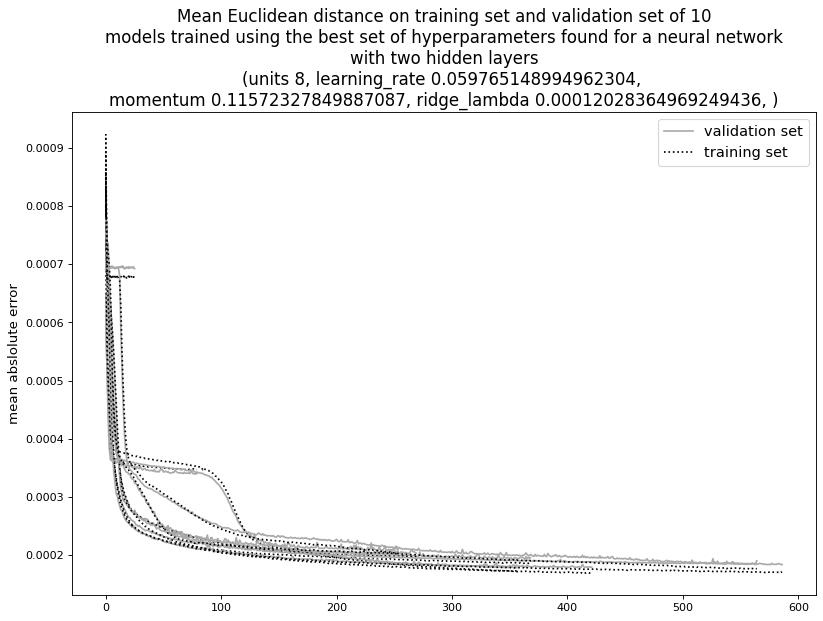

In [40]:
total_hp = 4
labels2 = ""
count = 1
for h_param in ["units", "learning_rate", "momentum", "ridge_lambda"]:
    hp_str = best_hp4[0].get(h_param)
    if (h_param == 'units'):
        hp_str *= 2
    labels2 += h_param + " " + str(hp_str) + ", "
    if(count % 2 == 0 and count != total_hp):
        labels2 += "\n"
    count += 1

list_values_val = [None]*n_trials
list_values_tr = [None]*n_trials

colours = ["darkgray", "black"]
linestyles = ["solid", "dotted"]

for i in range(n_trials):
    list_values_val[i] = hist2[i].history['val_<lambda>']
    list_values_tr[i] = hist2[i].history['<lambda>']
        
max_length = 0
for i in range(n_trials):
    if (max_length < len(list_values_tr[i])):
        max_length = len(list_values_tr[i])
        
time_ep = list(range(max_length))

plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values_val[i])], list_values_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values_tr[i])], list_values_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

legend = ["validation set", "training set"]

plt.title(
    "Mean Euclidean distance on training set and validation set of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with two hidden layers\n("
    + labels2 + ")", size=15
)

plt.ylabel("mean abslolute error", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/med_double_layer.png")
plt.show()

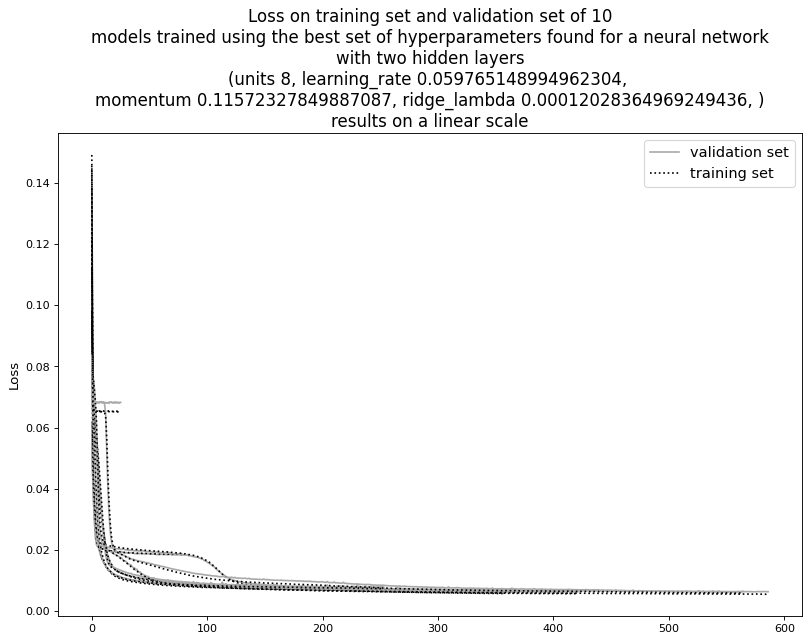

In [41]:
list_values2_val = [None]*n_trials
list_values2_tr = [None]*n_trials

for i in range(n_trials):
    list_values2_val[i] = hist2[i].history['val_loss']
    list_values2_tr[i] = hist2[i].history['loss']

plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values2_val[i])], list_values2_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values2_tr[i])], list_values2_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

plt.title(
    "Loss on training set and validation set of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with two hidden layers\n("
    + labels2 + ")\n" +
    "results on a linear scale", size=15
)

plt.ylabel("Loss", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/ms_loss_double_layer.png")
plt.show()

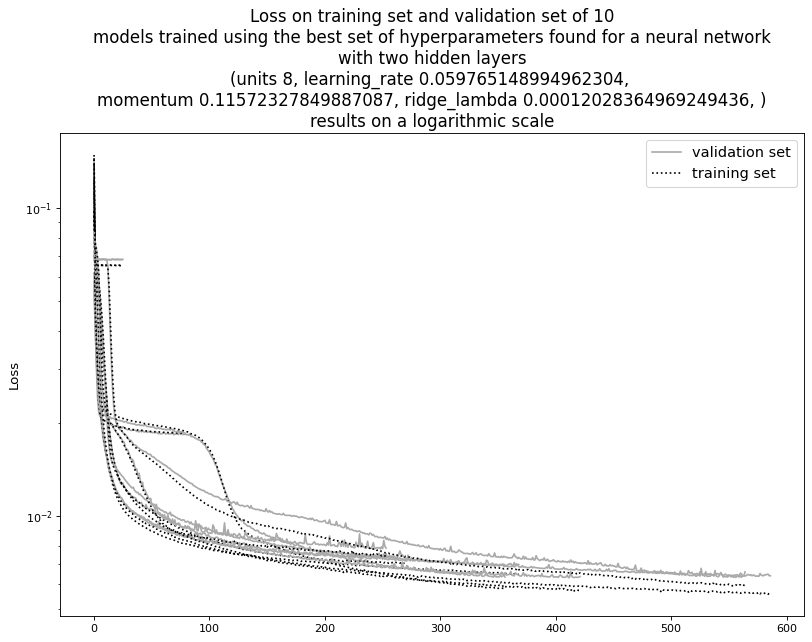

In [42]:
plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values2_val[i])], list_values2_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values2_tr[i])], list_values2_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

plt.title(
    "Loss on training set and validation set of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with two hidden layers\n("
    + labels2 + ")\n" +
    "results on a logarithmic scale", size=15
)

plt.ylabel("Loss", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/ms_loss_double_layer_log.png")
plt.yscale('log')
plt.show()

The neural networks with only one hidden layer have better results with respect to the others with two hidden layers. Therefore we decided to return a model among the ones obtained using a single hidden layer.  To retrieve a final model among the ones obtained using a random search, we chose the average model (among those having a single hidden layer) in terms of mean absolute error
on the validation set

In [43]:
for i in range(n_trials):
    list_values_val[i] = hist[i].history['val_<lambda>']

final_values_val = [None]*n_trials
for i in range(n_trials):
    final_values_val[i] = list_values_val[i][len(list_values_val[i]) - 1]

list_scores = [None]*n_trials
for i in range(n_trials):
    list_scores[i] = [final_values_val[i], i]
    
list_scores = sorted(list_scores, key=itemgetter(0))

for i in range(n_trials):
    scr = list_scores[i][0]

index = list_scores[int(n_trials/2)][1]

avg_model_val_err = hist[index].history['val_<lambda>']
list_length = len(avg_model_val_err)
final_val_err = avg_model_val_err[list_length - 1]


print(
    "The validation error on the final model for NN with random search is "
      + str(final_val_err) + "\n"
)

avg_model = models[index]
avg_model.save("results/ml_cup/nn_RandomSearch/avg_model_single_layer/")

The validation error on the final model for NN with random search is 0.00018641111091710627

INFO:tensorflow:Assets written to: results/ml_cup/nn_RandomSearch/avg_model_single_layer/assets


In conclusion, we want to observe the generalization capabilities of our model with respect to the real targets

In [45]:
# Restore the original training set
x_mlcup_tr = x_mlcup_ds
y_mlcup_tr = y_mlcup_ds

print(len(x_mlcup_tr))

predicted_target_tr = avg_model.predict(x_mlcup_tr)

print("differenza in lunghezze: ", len(predicted_target_tr), " e ", len(y_mlcup_tr), "\n\n")

for i in range(len(predicted_target_tr)):
        
    print("valore predetto ", predicted_target_tr[i])
    
    print("valore reale ", y_mlcup_tr[i])
    
    print("\n")

1492
47/47 [==============================] - 0s 864us/step
differenza in lunghezze:  1492  e  1492 


valore predetto  [0.92161703 0.31629413]
valore reale  [0.88921196 0.3676885 ]


valore predetto  [0.7112582  0.26871487]
valore reale  [0.74337106 0.29578539]


valore predetto  [0.09658767 0.716437  ]
valore reale  [0.11856858 0.82513027]


valore predetto  [0.3116564  0.26805323]
valore reale  [0.36630619 0.20784845]


valore predetto  [0.1264776  0.63547534]
valore reale  [0.13292608 0.87004932]


valore predetto  [0.1418091 0.6547291]
valore reale  [0.13799254 0.81698598]


valore predetto  [0.37384963 0.20129713]
valore reale  [0.33138564 0.26444279]


valore predetto  [0.12257793 0.611681  ]
valore reale  [0.08398329 0.56948234]


valore predetto  [0.51198155 0.24226373]
valore reale  [0.5212342  0.20414567]


valore predetto  [0.8447559  0.39047325]
valore reale  [0.80938269 0.30518688]


valore predetto  [0.7373702  0.33696952]
valore reale  [0.89155794 0.37112307]


valore p

valore reale  [0.34981252 0.23692444]


valore predetto  [0.23176438 0.29730755]
valore reale  [0.24703908 0.31567855]


valore predetto  [0.17347033 0.43675965]
valore reale  [0.09325083 0.65678524]


valore predetto  [0.85658056 0.3207497 ]
valore reale  [0.917065   0.37967347]


valore predetto  [0.13287082 0.55556476]
valore reale  [0.12613658 0.47182484]


valore predetto  [0.09869263 0.8886298 ]
valore reale  [0.14764772 0.94257731]


valore predetto  [0.19864705 0.36008662]
valore reale  [0.16975361 0.39896042]


valore predetto  [0.7888935 0.3192333]
valore reale  [0.88462568 0.3662777 ]


valore predetto  [0.44683358 0.16816437]
valore reale  [0.51090115 0.19971601]


valore predetto  [0.15184423 0.5502665 ]
valore reale  [0.09865853 0.51212411]


valore predetto  [0.8293033 0.2831324]
valore reale  [0.87274521 0.36746266]


valore predetto  [0.5495808 0.183335 ]
valore reale  [0.57333297 0.21854398]


valore predetto  [0.15353063 0.42111158]
valore reale  [0.10675471 0.585904

valore predetto  [0.7305653 0.318211 ]
valore reale  [0.82429276 0.34773806]


valore predetto  [0.06752348 0.88299334]
valore reale  [0.1385313  0.95044512]


valore predetto  [0.11982966 0.66833043]
valore reale  [0.11811787 0.76903444]


valore predetto  [0.8265814 0.304098 ]
valore reale  [0.8369152  0.29158335]


valore predetto  [0.5927191  0.14583403]
valore reale  [0.67867096 0.26779272]


valore predetto  [0.43083987 0.17052594]
valore reale  [0.40881156 0.15805239]


valore predetto  [0.14437336 0.48075983]
valore reale  [0.15050279 0.4262902 ]


valore predetto  [0.14597964 0.79746723]
valore reale  [0.1363034  0.97930943]


valore predetto  [0.2734715  0.23130646]
valore reale  [0.34495735 0.2413829 ]


valore predetto  [0.12400325 0.78367984]
valore reale  [0.11988886 0.90824234]


valore predetto  [0.9068916  0.32576147]
valore reale  [0.90373312 0.37101838]


valore predetto  [0.18046817 0.50750357]
valore reale  [0.11448308 0.48617805]


valore predetto  [0.45799583 0.2

valore predetto  [0.13083631 0.52930486]
valore reale  [0.13384206 0.46409588]


valore predetto  [0.13316433 0.9262151 ]
valore reale  [0.1428332  0.91766759]


valore predetto  [0.14614485 0.584837  ]
valore reale  [0.11208301 0.53977209]


valore predetto  [0.13979264 0.7982825 ]
valore reale  [0.14124693 0.99777946]


valore predetto  [0.11514091 0.6271659 ]
valore reale  [0.09805841 0.55352826]


valore predetto  [0.6711604  0.19267684]
valore reale  [0.57517453 0.21619895]


valore predetto  [0.7783531  0.30342713]
valore reale  [0.71066762 0.15082564]


valore predetto  [0.8572036  0.29298657]
valore reale  [0.91075151 0.379702  ]


valore predetto  [0.5929549  0.20471123]
valore reale  [0.62427831 0.22865802]


valore predetto  [0.6140795  0.15619254]
valore reale  [0.64291301 0.25994963]


valore predetto  [0.612926  0.1896629]
valore reale  [0.69265396 0.27684871]


valore predetto  [0.5717084  0.19496658]
valore reale  [0.69134064 0.25190289]


valore predetto  [0.2480543 0.

valore predetto  [0.85247374 0.36744735]
valore reale  [0.88324558 0.36828366]


valore predetto  [0.2986727  0.26583466]
valore reale  [0.34813037 0.11713785]


valore predetto  [0.39940575 0.16874489]
valore reale  [0.48315968 0.17788258]


valore predetto  [0.8881403  0.31544733]
valore reale  [0.90743651 0.3887574 ]


valore predetto  [0.13233873 0.6634029 ]
valore reale  [0.11636393 0.56304978]


valore predetto  [0.11142401 0.67282027]
valore reale  [0.07659678 0.7180021 ]


valore predetto  [0.7989512  0.34923035]
valore reale  [0.84595126 0.35211715]


valore predetto  [0.75626224 0.31351602]
valore reale  [0.81668858 0.33335332]


valore predetto  [0.13911593 0.55526346]
valore reale  [0.11445516 0.64974207]


valore predetto  [0.8256066  0.29619667]
valore reale  [0.84126009 0.33869784]


valore predetto  [0.7882039  0.31380555]
valore reale  [0.78114716 0.3327912 ]


valore predetto  [0.5760266  0.16992134]
valore reale  [0.57554479 0.22241468]


valore predetto  [0.6974821 

valore reale  [0.12078115 0.61028628]


valore predetto  [0.4922873  0.22055435]
valore reale  [0.53965395 0.21530673]


valore predetto  [0.6933852  0.24478322]
valore reale  [0.6383435 0.2549933]


valore predetto  [0.16110541 0.7996726 ]
valore reale  [0.14953657 0.89852351]


valore predetto  [0.8330777  0.28390908]
valore reale  [0.77000175 0.31463868]


valore predetto  [0.4343839  0.24533218]
valore reale  [0.48003709 0.18701414]


valore predetto  [0.11361784 0.7776184 ]
valore reale  [0.13504461 0.76532297]


valore predetto  [0.12901717 0.656114  ]
valore reale  [0.09700496 0.61360817]


valore predetto  [0.13743556 0.57911813]
valore reale  [0.09791879 0.57755739]


valore predetto  [0.19277272 0.3881625 ]
valore reale  [0.26051391 0.31321978]


valore predetto  [0.6419445  0.19985443]
valore reale  [0.55411156 0.22187283]


valore predetto  [0.8827773  0.31450453]
valore reale  [0.90960315 0.37362588]


valore predetto  [0.42304653 0.20981702]
valore reale  [0.51602865 0.19

valore predetto  [0.48029026 0.26407346]
valore reale  [0.49951107 0.07735082]


valore predetto  [0.16344681 0.48232234]
valore reale  [0.26924141 0.28889331]


valore predetto  [0.29058945 0.27047366]
valore reale  [0.27093841 0.29558078]


valore predetto  [0.4597986  0.21498874]
valore reale  [0.44599738 0.14913058]


valore predetto  [0.8120545  0.27495253]
valore reale  [0.79397533 0.32938935]


valore predetto  [0.85372674 0.41155878]
valore reale  [0.95173122 0.39103774]


valore predetto  [0.5007041  0.16809434]
valore reale  [0.49454102 0.12249041]


valore predetto  [0.19269533 0.39279503]
valore reale  [0.2443481  0.25178302]


valore predetto  [0.65358764 0.30409527]
valore reale  [0.76509497 0.20513282]


valore predetto  [0.81529975 0.33714676]
valore reale  [0.78366374 0.32519058]


valore predetto  [0.20004362 0.34750527]
valore reale  [0.27561691 0.29017346]


valore predetto  [0.48486617 0.26606885]
valore reale  [0.5159004  0.20092853]


valore predetto  [0.5671608 

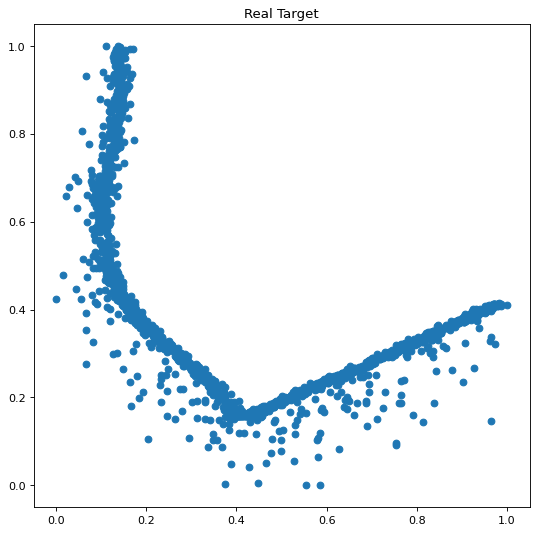

In [48]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(y_mlcup_ds[:, 0], y_mlcup_ds[:, 1])
plt.title("Real Target")
plt.savefig("./plots/ml_cup/nn_RandomSearch/real_target.png")
plt.show()

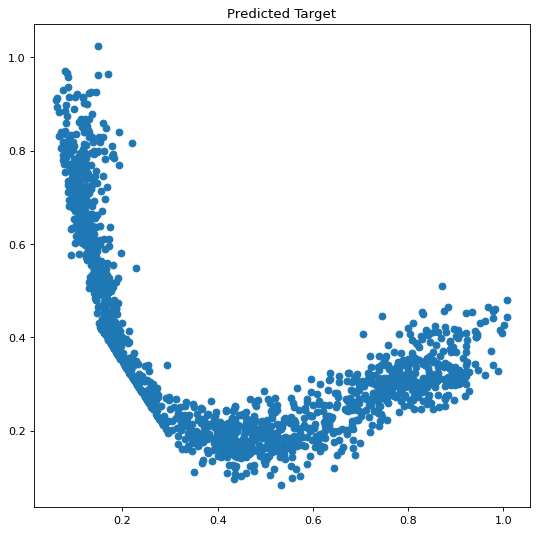

In [49]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(predicted_target_tr[:, 0], predicted_target_tr[:, 1])
plt.title("Predicted Target")
plt.savefig("./plots/ml_cup/nn_RandomSearch/predicted_target.png")
plt.show()